# Νευρωνικά Δίκτυα

Παρακάτω θα παρουσιάσουμε μερικές αρχιτεκτονικές νευρωνικών δικτύων.

***

## Συναρτήσεις 

Οι παρακάτω βοηθητικές συναρτήσεις θα χρησιμοποιηθούν για να κάνουμε train και test το μοντέλο.

Αρχικά κάνουμε τα απαραίτητα imports και ορίζουμε την συσκευή που θα χρησιμοποιήσουμε (cpu/gpu).

In [58]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
import pandas as pd
import os
from torch.optim import lr_scheduler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from pathlib import Path
from sklearn.model_selection import KFold
import plotly.graph_objects as go
import random


BATCH_SIZE = 32
# For implementation of ReLock
labels_holdout = []
info_holdout = []
torch.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device, imports complete!'.format(device))

Using cuda device, imports complete!


Στην συνέχεια ορίζουμε την πρώτη συνάρτηση η οποία δέχεται ένα μοντέλο, το training dataset, την συνάρτηση λάθους, τον optimizer, και την συσκευή που χρησιμοποιούμε. Προχωράει το training κατά ένα βήμα και επιστρέφει την απώλεια.

In [59]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = 'cpu'):
    model.to(device)
    model.train()

    train_loss = 0
    for X_batch, y_batch in data_loader:
        # Send data to GPU
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        y_pred = model(X_batch)

        # Compute loss
        loss = loss_fn(y_pred, y_batch)

        # Zero gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update the weights
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping to prevent gradients exploding
        optimizer.step()

        train_loss += loss.item()
    
    return train_loss


Ομοίως η παρακάτω συνάρτηση κάνει test το μοντέλο σε κάθε εποχή, και επιστρέφει την απώλεια.

In [60]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = 'cpu'):
    model.to(device)
    model.eval()

    test_loss = 0
    with torch.inference_mode():
        for X_batch, y_batch in data_loader:
            # Send data to GPU
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_test_pred = model(X_batch)
            test_loss += loss_fn(y_test_pred, y_batch).item()
    
    return test_loss

Ορίζουμε μία κλάση έτσι ώστε το μοντέλο μας να σταματάει νωρίς όταν παρατηρεί ότι το test loss αυξάνεται η μέθοδος αυτή είναι γνωστή και ως early stopping.

In [61]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0, verbose=False, path='best_model.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.path = path

        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.path)
            if self.verbose:
                print(f"Validation loss decreased to {val_loss:.6f}. Saving model...")
        else:
            self.counter += 1
            if self.verbose:
                print(f"No improvement. Counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
    
    def get_best_loss(self):
        return self.best_loss

Η βασική συνάρτηση, επαναληπτικά για όσες εποχές έχουμε διαλέξει κάνει train και test το μοντέλο, και ανά 10 εποχές εκτυπώνει τα αποτελέσματα. Επιστρέφει 2 πίνακες με τις συνολικές απώλειες σε κάθε επανάληψη.

In [62]:
def train_test_model(epoch: int, 
                     model: torch.nn.Module,
                     train_loader: torch.utils.data.DataLoader,
                     test_loader: torch.utils.data.DataLoader,
                     loss_fn: torch.nn.Module,
                     optimizer: torch.optim.Optimizer,
                     scheduler,
                     early_stopper = None,
                     device: torch.device = 'cpu',
                     test: bool = True,
                     verbose: bool = True):

    torch.manual_seed(42)
    train_loss_arr = []
    test_loss_arr = []
    
    if(test):
        for epochs in range(epoch):
            # Train for one epoch
            epoch_loss = train_step(model, train_loader, loss_fn, optimizer, device)
            train_loss_arr.append(epoch_loss / len(train_loader))

            # Scheduler update
            scheduler.step(epoch_loss)
            after_lr = optimizer.param_groups[0]['lr']

            # Evaluate on test set
            test_loss = test_step(model, test_loader, loss_fn, device)
            test_loss_arr.append(test_loss / len(test_loader))

            # Print progress
            if verbose == True:
                if (epochs % 10 == 0) or (epochs == 0):
                    print(f'Epoch {epochs} | Loss train: {train_loss_arr[-1]:.6f} | Loss test: {test_loss_arr[-1]:.6f} | lr = {after_lr}')
                elif epochs + 1 == epoch:
                    print(f'Epoch {epoch} | Loss train: {train_loss_arr[-1]:.6f} | Loss test: {test_loss_arr[-1]:.6f} | lr = {after_lr}')

            # Early stopping check
            early_stopper(test_loss_arr[-1], model)
            if early_stopper.early_stop:
                if verbose == True:
                    print(f"Early stopping at epoch {epochs}")
                break

        # Load the best model weights after stopping
        if early_stopper.path is not None:
            model.load_state_dict(torch.load(early_stopper.path, weights_only= True))
            if verbose == True:
                print(f"Loaded best model from {early_stopper.path}")

        return train_loss_arr, test_loss_arr, early_stopper.get_best_loss(), epochs
    else:
        for epochs in range(epoch):
            # Train for one epoch
            epoch_loss = train_step(model, train_loader, loss_fn, optimizer, device)
            train_loss_arr.append(epoch_loss / len(train_loader))

            # Scheduler update
            scheduler.step(epoch_loss)
            after_lr = optimizer.param_groups[0]['lr']

            # Print progress
            if verbose == True:
                if (epochs % 10 == 0) or (epochs == 0):
                    print(f'Epoch {epochs} | Loss train: {train_loss_arr[-1]:.6f} | lr = {after_lr}')
                elif epochs + 1 == epoch:
                    print(f'Epoch {epoch} | Loss train: {train_loss_arr[-1]:.6f} | lr = {after_lr}')
        return train_loss_arr

Η συνάρτηση είναι παρόμοια με την test_step με την διαφορά ότι επιστρέφει ένα dictionary με τα βασικά στοιχεία του μοντέλου.

In [63]:
def eval_model_3d(model: torch.nn.Module, 
                  data_loader: torch.utils.data.DataLoader, 
                  scaler,
                  device: torch.device = 'cpu',
                  verbose=True):

    model.eval()
    model.to(device)
    all_preds = []
    all_targets = []

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)

            # Move to CPU and collect all predictions and targets
            all_preds.append(y_pred.cpu())
            all_targets.append(y.cpu())

    # Concatenate all batches
    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_targets = torch.cat(all_targets, dim=0).numpy()

    # Reverse scaling
    y_pred_real = scaler.inverse_transform(all_preds)
    y_true_real = scaler.inverse_transform(all_targets)

    # Calculate average Euclidean distance (in cm)
    distances = np.linalg.norm(y_pred_real - y_true_real, axis=1)
    mean_distance_error = np.mean(distances)
    std_distance_error = np.std(distances)

    # Plot real data VS predicted in 3D
    if verbose:
        fig = plt.figure(figsize=(15, 15))
        ax = fig.add_subplot(111, projection='3d')

        number_of_points = len(distances)

        # Plot ground truth points
        ax.scatter(
            y_true_real[:number_of_points, 0], 
            y_true_real[:number_of_points, 1], 
            y_true_real[:number_of_points, 2], 
            color='blue', label='Ground Truth', s=100
        )

        # Plot predicted points
        ax.scatter(
            y_pred_real[:number_of_points, 0], 
            y_pred_real[:number_of_points, 1], 
            y_pred_real[:number_of_points, 2], 
            color='red', label='Predicted', s=100
        )

        # Draw lines connecting corresponding points
        for i, (gt, pred) in enumerate(zip(y_true_real[:number_of_points], y_pred_real[:number_of_points])):
            ax.plot(
                [gt[0], pred[0]], 
                [gt[1], pred[1]], 
                [gt[2], pred[2]], 
                color='gray', linestyle='--', linewidth=1
            )
            
            # Calculate the midpoint of the line for placing the text
            mid_x = (gt[0] + pred[0]) / 2
            mid_y = (gt[1] + pred[1]) / 2
            mid_z = (gt[2] + pred[2]) / 2
            
            # Annotate the line with the corresponding distance from the distances array
            ax.text(mid_x, mid_y, mid_z, f'{distances[i]:.2f} cm', fontsize=9, ha='center', va='bottom', color='black',
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.3))

        # Add labels and legend
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title(f'Ground Truth vs Predicted Points\nMean Distance Error: {mean_distance_error:.2f} cm, Std: {std_distance_error:.2f} cm')
        ax.legend()
        ax.grid(True)

        # Show the plot
        plt.show()

    return {
        "model_name": model.__class__.__name__,
        "mean_distance_error_cm": mean_distance_error.item(),
        "std": std_distance_error.item()
    }

Η συνάρτηση αυτή χρησιμοποιείται για να εμφανίσει τις κανονικοποιημένες στο (0,1) train_loss και test_loss curves.

In [64]:
def plot_results(train_arr, test_arr):
    # Plot the loss curves
    train_arr = (train_arr - np.min(train_arr)) / (np.max(train_arr) - np.min(train_arr))
    test_arr = (test_arr - np.min(test_arr)) / (np.max(test_arr) - np.min(test_arr))
    
    plt.figure(figsize=(8, 5))
    plt.plot(train_arr, label='Train Loss')
    plt.plot(test_arr, label='Test Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Normalized Loss")
    plt.title("Normalized Training Loss")
    plt.grid()
    plt.legend()
    plt.show()

***

## Εισαγωγή δεδομένων

Κάνουμε scale και το Y οπότε σε περίπτωση τυχαίου διανύσματος θα πρέπει να το κάνουμε και αυτό scale, και μετά το output να το επαναφέρουμε.

Έχοντας δοκιμάσει να κανονικοποιήσουμε τα δεδομένα εισόδου σε [-1,1] και τα δεδομένα εξόδου με την χρήση του standardscaler, τα αποτελέσματα είναι **ελαφρώς χειρότερα** από το να κανονικοποιήσουμε και την είσοδο και την έξοδο με τον standard scaler.

Κάνοντας χρήση της μεθόδου [-1,1] τοσο για την είσοδο όσο για την έξοδο τα αποτελέσματα είναι **σαφώς χειρότερα**

Για την ώρα κρατάμε το [-1,1] για την είσοδο και το StandardScaler για την έξοδο.

Ανάλογα με τον ποιον φάκελο θέλουμε να διαβάσουμε αλλάζουμε το νουμεράκι.

In [65]:
# Get the directory of the script
parent_dir = Path(__file__).parent if "__file__" in globals() else Path.cwd()

#parent_dir = os.path.join(parent_dir, '..', 'Experiments', 'Raw_Data_Double_Antenna_0','No_Offset') 
parent_dir = os.path.join(parent_dir, '..','..','..' ,'Experiments', 'Raw_Data_Quadruple_Antenna_0') 

data = np.load(f"{parent_dir}\\final_tensor.npy")
labels = np.load(f"{parent_dir}\\final_labels.npy")

cv_train_data, cv_test_data, cv_train_labels, cv_test_labels = train_test_split(
        data, labels, test_size=0.1, random_state=42
    )

cv_train_data.shape, cv_test_data.shape, cv_train_labels.shape, cv_test_labels.shape

((165, 385, 16), (19, 385, 16), (165, 3), (19, 3))

In [66]:
print(cv_train_data[0,:,14])

[192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8
 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8
 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8
 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8
 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8
 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8
 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8
 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8
 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8
 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8
 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8
 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8
 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8
 192.8 192.8 192.8 192.8 192.8 192.8 192.8 192.8 19

ADD z-OFFSET

In [67]:
final_train_data = []
final_test_data = []
final_train_labels = []
final_test_labels = []
np.random.seed(42)
for i in range(50):
    z_offset = np.random.rand()*100
    offset_train_data = cv_train_data.copy()
    offset_train_data[:,:,2] = cv_train_data[:,:,2] + z_offset
    offset_train_data[:,:,6] = cv_train_data[:,:,6] + z_offset
    offset_train_data[:,:,10] = cv_train_data[:,:,10] + z_offset
    offset_train_data[:,:,14] = cv_train_data[:,:,14] + z_offset
    final_train_data.append(np.array(offset_train_data))
    offset_train_labels = cv_train_labels.copy()
    offset_train_labels[:,2] = cv_train_labels[:,2] + z_offset
    final_train_labels.append(np.array(offset_train_labels))
    offset_test_data = cv_test_data.copy()
    offset_test_data[:,:,2] = cv_test_data[:,:,2] + z_offset    
    offset_test_data[:,:,6] = cv_test_data[:,:,6] + z_offset
    offset_test_data[:,:,10] = cv_test_data[:,:,10] + z_offset
    offset_test_data[:,:,14] = cv_test_data[:,:,14] + z_offset
    final_test_data.append(np.array(offset_test_data))
    offset_test_labels = cv_test_labels.copy()
    offset_test_labels[:,2] = cv_test_labels[:,2] + z_offset
    final_test_labels.append(np.array(offset_test_labels))

cv_train_data = np.concatenate(final_train_data, axis=0)
cv_test_data = np.concatenate(final_test_data, axis=0)
cv_train_labels = np.concatenate(final_train_labels, axis=0)
cv_test_labels = np.concatenate(final_test_labels, axis=0)

cv_train_data.shape, cv_test_data.shape, cv_train_labels.shape, cv_test_labels.shape

((8250, 385, 16), (950, 385, 16), (8250, 3), (950, 3))

Ουσιαστικά αναζητούμε τα **Χ και Υ** του RFID TAG, γνωρίζοντας το πως **κινήθηκε** και την μέτρηση της **φάσης** του.

Αποθηκεύουμε σε μεταβλητές τα μεγέθη του input και του output για τα γραμμικά μοντέλα.

In [68]:
output_len = cv_train_labels.shape[1]
input_len = cv_train_data.shape[1] * cv_train_data.shape[2]

input_len,output_len

(6160, 3)

### NORMALIZATION PROOF

In [38]:
for dataset in [cv_train_data, cv_test_data]:
    for i in range(len(dataset)):
        for j in range(dataset.shape[2]):
            if (j + 1) % 4 == 0:
                dataset[i, :, j] -= np.min(dataset[i, :, j])
                
abs_max = np.abs(cv_train_data).max(axis=(0,1))  # max per feature over (samples, time)

# Reshape to 4 rows, 4 columns
abs_max = abs_max.reshape(4, 4)

# Find the max of each column
col_max = abs_max.max(axis=0)

col_max[0], col_max[1] = max(col_max[0], col_max[1]), max(col_max[0], col_max[1])

# Replace each column with its max value
abs_max = np.tile(col_max, (abs_max.shape[0], 1))

abs_max = abs_max.flatten()

test = cv_train_data/abs_max


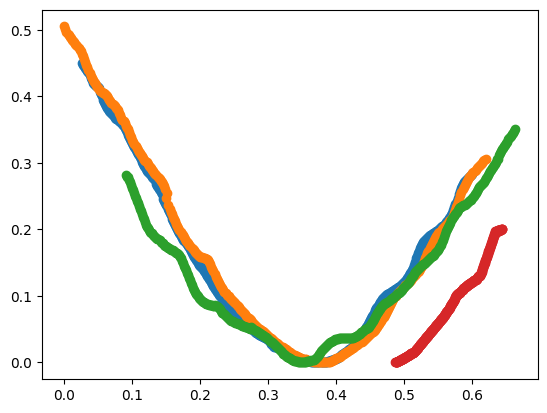

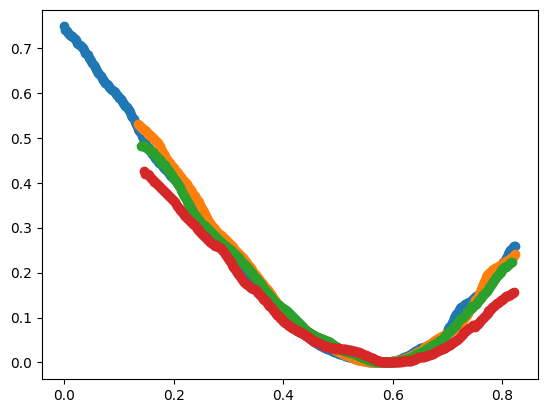

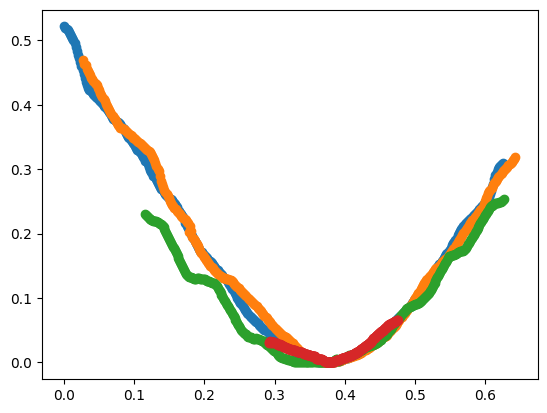

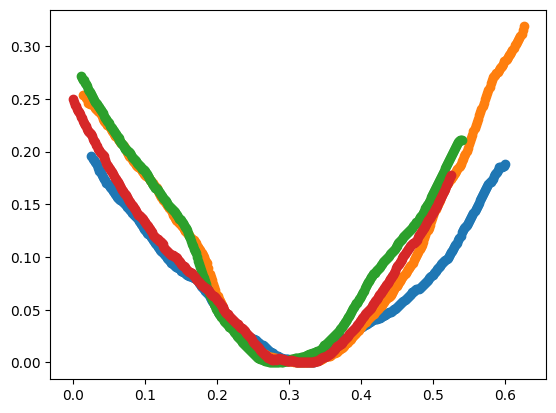

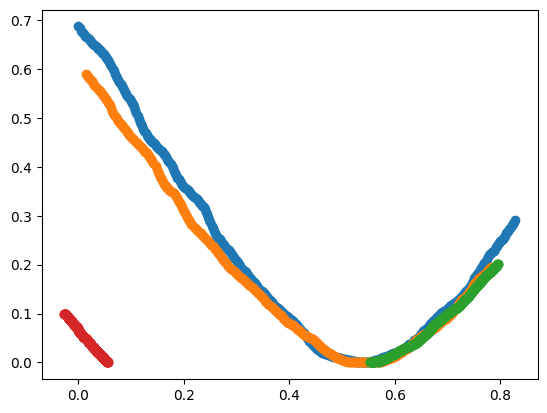

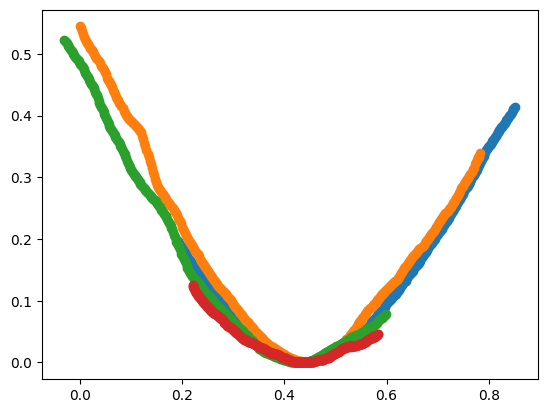

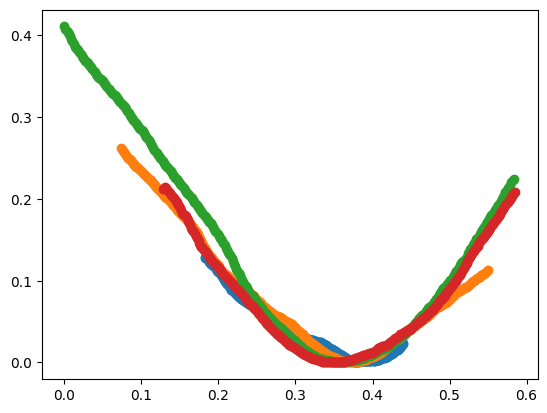

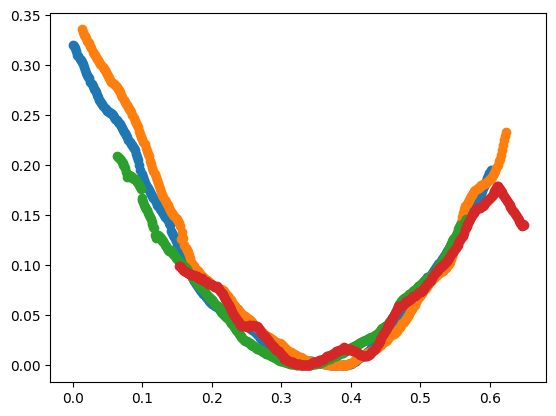

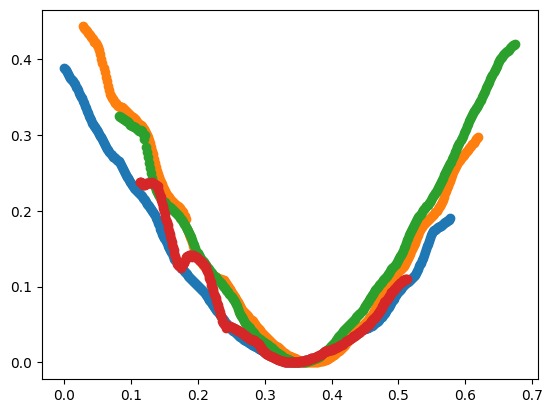

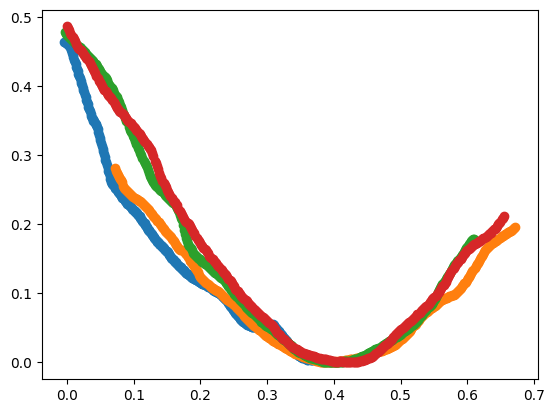

In [39]:
for sample in random.sample(range(len(test)), 10): 
    plt.scatter(test[sample, :, 0],test[sample, :, 3])
    plt.scatter(test[sample, :, 4],test[sample, :, 7])
    plt.scatter(test[sample, :, 8],test[sample, :, 11])
    plt.scatter(test[sample, :, 12],test[sample, :, 15])
    #plt.axvline(x = tag_pos_array[sample, 0], color = 'b')
    plt.show()

***

### Heatmap

In [40]:
from scipy.ndimage import gaussian_filter
# Extract x, y, z coordinates from the RFID labels
x = cv_train_labels[:, 0]
y = cv_train_labels[:, 1]
z = cv_train_labels[:, 2]  # Assuming you have a z coordinate

# Create a 3D histogram
bins = 30  # Adjust for resolution
hist, edges = np.histogramdd((x, y, z), bins=bins)

# Apply Gaussian smoothing
hist_smoothed = gaussian_filter(hist, sigma=2)

# Get bin centers for plotting
x_edges, y_edges, z_edges = edges
x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2
z_centers = (z_edges[:-1] + z_edges[1:]) / 2

# Flatten for scatter plot representation
xv, yv, zv = np.meshgrid(x_centers, y_centers, z_centers, indexing="ij")
xv, yv, zv, values = xv.flatten(), yv.flatten(), zv.flatten(), hist_smoothed.flatten()


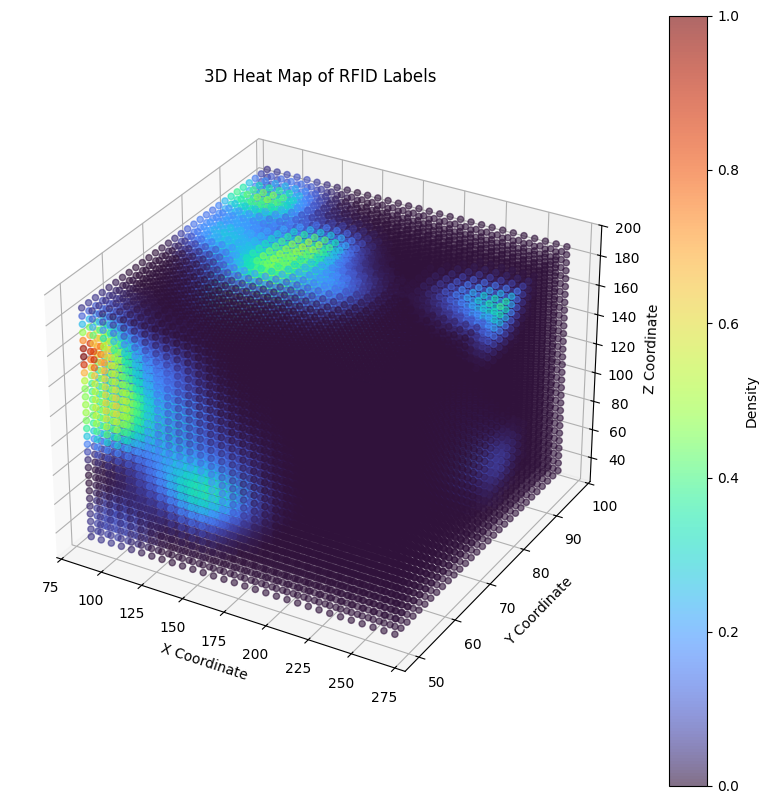

In [41]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Normalize values for color mapping
normalized_values = (values - values.min()) / (values.max() - values.min())

# Plot the points, using density as color & size
sc = ax.scatter(xv, yv, zv, c=normalized_values, cmap='turbo', s=20, alpha=0.6)

# Add color bar
cbar = plt.colorbar(sc)
cbar.set_label('Density')

ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
ax.set_title('3D Heat Map of RFID Labels')

plt.show()

***

Η ```data_func_cv``` δέχεται σαν ορίσματα τον πίνακα δεδομένων και τον πίνακα των tags καθώς και τους δείκτες από τους οποίους ξεκινάει το subset του cross_validation, τα κανονικοποιεί και επιστρέφει τα datasets καθώς και τον scaler που χρησιμοποίησε.

In [42]:
def data_func_cv(input_array, labels, train_idx, val_idx, batch_size=32):
    # Trim into subset
    X_train_raw = input_array[train_idx]
    X_test_raw = input_array[val_idx]
    y_train = labels[train_idx, :]
    y_test = labels[val_idx, :]

    for dataset in [X_train_raw, X_test_raw]:
        for i in range(len(dataset)):
            for j in range(dataset.shape[2]):
                if (j + 1) % 4 == 0:
                    dataset[i, :, j] -= np.min(dataset[i, :, j])
                    
    abs_max = np.abs(X_train_raw).max(axis=(0,1))  # max per feature over (samples, time)

    # Reshape to 4 rows, 4 columns
    abs_max = abs_max.reshape(4, 4)

    # Find the max of each column
    col_max = abs_max.max(axis=0)

    # Force Y max to be X max
    col_max[0], col_max[1] = max(col_max[0], col_max[1]), max(col_max[0], col_max[1])

    # Replace each column with its max value
    abs_max = np.tile(col_max, (abs_max.shape[0], 1))
    
    abs_max = abs_max.flatten()

    # Prevent division by zero
    abs_max[abs_max == 0] = 1.0

    # Normalize per feature
    X_train_norm = X_train_raw / abs_max  
    X_test_norm = X_test_raw / abs_max  

    # Now reshape for linear model
    X_train_scaled = X_train_norm.reshape(len(X_train_norm), -1)  
    X_test_scaled = X_test_norm.reshape(len(X_test_norm), -1)   

    # Scale Y with StandardScaler (correct approach)
    scaler_Y = StandardScaler()
    y_train_scaled = scaler_Y.fit_transform(y_train)
    y_test_scaled = scaler_Y.transform(y_test)

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

    # Dataloaders
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    test_data = TensorDataset(X_test_tensor, y_test_tensor)

    g = torch.Generator()
    g.manual_seed(42)

    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, generator=g)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

    return train_loader, test_loader, scaler_Y


Η ```data_func_eval``` θα χρησιμοποιηθεί για το τελικό μοντέλο που θα προκύψει μετα το CV, κανονικοποιεί τα δεδομένα και επιστρέφει τα datasets και τον scaler.

In [43]:
def data_func_eval(X_main, X_holdout, y_main, y_holdout, batch_size = 32):
    for dataset in [X_main, X_holdout]:
        for i in range(len(dataset)):
            for j in range(dataset.shape[2]):
                if (j + 1) % 4 == 0:
                    dataset[i, :, j] -= np.min(dataset[i, :, j])
                    
    abs_max = np.abs(X_main).max(axis=(0,1))  # max per feature over (samples, time)

    # Reshape to 4 rows, 4 columns
    abs_max = abs_max.reshape(4, 4)

    # Find the max of each column
    col_max = abs_max.max(axis=0)

    col_max[0], col_max[1] = max(col_max[0], col_max[1]), max(col_max[0], col_max[1])

    # Replace each column with its max value
    abs_max = np.tile(col_max, (abs_max.shape[0], 1))
    
    abs_max = abs_max.flatten()
    
    # Prevent division by zero
    abs_max[abs_max == 0] = 1.0

    # Normalize per feature
    X_train_norm = X_main / abs_max  # shape (N_train, 500, 4)
    X_test_norm = X_holdout / abs_max    # shape (N_test, 500, 4)

    # Now reshape for linear model
    X_train_scaled = X_train_norm.reshape(len(X_train_norm), -1)  # (N_train, 2000)
    X_test_scaled = X_test_norm.reshape(len(X_test_norm), -1)     # (N_test, 2000)

    # Scale Y with StandardScaler (correct approach)
    scaler_Y = StandardScaler()
    y_main_scaled = scaler_Y.fit_transform(y_main)
    y_holdout_scaled = scaler_Y.transform(y_holdout)

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_main_tensor = torch.tensor(y_main_scaled, dtype=torch.float32)
    y_holdout_tensor = torch.tensor(y_holdout_scaled, dtype=torch.float32)

    # Dataloaders
    train_data = TensorDataset(X_train_tensor, y_main_tensor)
    test_data = TensorDataset(X_test_tensor, y_holdout_tensor)

    g = torch.Generator()
    g.manual_seed(42)

    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, generator=g)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

    return train_loader, test_loader, scaler_Y

***

## Cross Validation 

Η κύρια συνάρτηση, δέχεται όλες τις παραμέτρους του μοντέλου, χωρίζει το dataset σε main και holdout, το main θα χρησιμοποιηθεί για το CV ενώ το holdout για το τελικό evaluation.

Χωρίζει το main dataset σε n_splits subsets , και προπονεί και τεστάρει το μοντέλο σε αυτά τα subsets έτσι ώστε να υπάρχει μία καλύτερη εικόνα των δεδομένων.

Μετά το CV, προπονεί το μοντέλο στο main dataset και το τεστάρει στο holdout που μέχρι τώρα δεν το έχει δει καθόλου το μοντέλο, αντιπροσωπέυοντας την real world case.

In [44]:
def cross_validation(X_main, y_main,X_holdout,y_holdout, n_splits, model, model_param, loss_fn, optimizer_1, optimizer_param, scheduler_param, early_stopper_param, epochs, device, verbose = True):

    # Initialize KFold
    kf = KFold(n_splits= n_splits, shuffle= True, random_state= 42)

    # Initialize arrays to store losses and epochs
    cv_losses = []
    epoch_array = []

    # Loop over the folds to perform cross-validation
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_main)):
        
        print(f"Fold {fold_idx + 1}")

        train_loader, test_loader, _ = data_func_cv(X_main, y_main, train_idx, val_idx, batch_size=BATCH_SIZE)
        # Instantiate the model
        model_0 = model(**model_param)

        loss_fn = loss_fn
        optimizer = optimizer_1(model_0.parameters(), **optimizer_param)

        # Initialize the scheduler
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, **scheduler_param)

        # Initialize early stopping
        early_stopper = EarlyStopping(**early_stopper_param)

        # Load the data
        arr1, arr2, best_loss, epoch_stop = train_test_model(epoch = epochs,model = model_0, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device, test= True, verbose = verbose)
        
        if verbose == True:
            plot_results(arr1, arr2)

        cv_losses.append(best_loss)
        epoch_array.append(epoch_stop)
    
    # Evaluate the final model
    train_loader, test_loader, scaler_Y = data_func_eval(X_main, X_holdout, y_main, y_holdout, batch_size=BATCH_SIZE)
    print(f"Cross-Validation finished with mean error across {n_splits} subsets = {np.mean(cv_losses)}, evaluating final model...")

    # Instantiate the model
    final_model = model(**model_param)

    final_optimizer = optimizer_1(final_model.parameters(), **optimizer_param)

    # Initialize the scheduler
    scheduler = lr_scheduler.ReduceLROnPlateau(final_optimizer, **scheduler_param)

    # Load the data
    arr1= train_test_model(epoch = np.max(epoch_array),model = final_model, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=final_optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device, test= False, verbose= verbose)

    result = eval_model_3d(model= final_model, data_loader= test_loader, scaler= scaler_Y, verbose= True)
    return result

***

## Αρχιτεκτονικές

#### LeakyRELU

Για την συγκεκριμένη αρχιτεκτονική και τα συγκεκριμένα ```hidden_units``` θα μελετήσουμε την διαφορά που προκαλούν διάφορες συναρτήσεις ενεργοποίησης.

Αρχικά μελετάμε την LeakyReLU, με τύπο:

$LeakyReLU(x) = max(0,x) + negative\_slope * min(0,x)$

In [69]:
class LeakyReLUModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(LeakyReLUModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= int(hidden_units/2)),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= int(hidden_units/2), out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Fold 1
Epoch 0 | Loss train: 2.390104 | Loss test: 0.444044 | lr = 0.01
Epoch 10 | Loss train: 0.082244 | Loss test: 0.084809 | lr = 0.01
Epoch 20 | Loss train: 0.045440 | Loss test: 0.039296 | lr = 0.01
Epoch 30 | Loss train: 0.041685 | Loss test: 0.032570 | lr = 0.01
Epoch 40 | Loss train: 0.034003 | Loss test: 0.023516 | lr = 0.01
Epoch 50 | Loss train: 0.090306 | Loss test: 0.254232 | lr = 0.01
Epoch 60 | Loss train: 0.001178 | Loss test: 0.000920 | lr = 0.001
Epoch 70 | Loss train: 0.000348 | Loss test: 0.000354 | lr = 0.001
Epoch 80 | Loss train: 0.000265 | Loss test: 0.000160 | lr = 0.001
Epoch 90 | Loss train: 0.000180 | Loss test: 0.000143 | lr = 0.001
Epoch 100 | Loss train: 0.000006 | Loss test: 0.000012 | lr = 0.0001
Epoch 110 | Loss train: 0.000003 | Loss test: 0.000007 | lr = 0.0001
Epoch 120 | Loss train: 0.000003 | Loss test: 0.000006 | lr = 0.0001
Epoch 130 | Loss train: 0.000001 | Loss test: 0.000006 | lr = 0.0001
Epoch 140 | Loss train: 0.000002 | Loss test: 0.000010

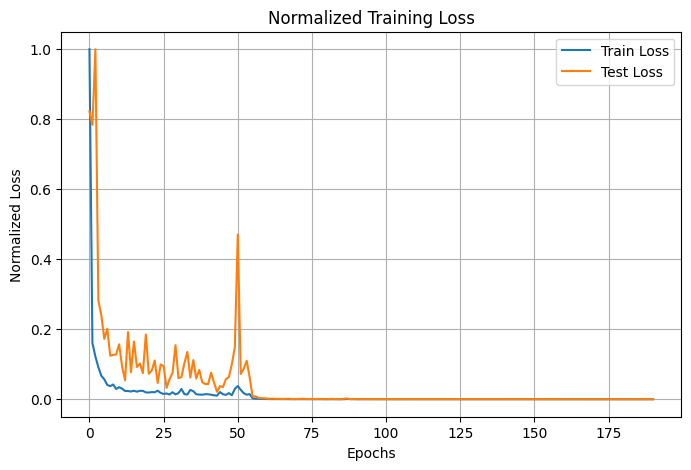

Fold 2
Epoch 0 | Loss train: 2.453190 | Loss test: 0.549107 | lr = 0.01
Epoch 10 | Loss train: 0.080582 | Loss test: 0.173577 | lr = 0.01
Epoch 20 | Loss train: 0.049561 | Loss test: 0.039548 | lr = 0.01
Epoch 30 | Loss train: 0.049719 | Loss test: 1.193632 | lr = 0.01
Epoch 40 | Loss train: 0.046374 | Loss test: 0.075443 | lr = 0.01
Epoch 50 | Loss train: 0.001771 | Loss test: 0.001502 | lr = 0.001
Epoch 60 | Loss train: 0.001059 | Loss test: 0.000681 | lr = 0.001
Epoch 70 | Loss train: 0.000704 | Loss test: 0.000441 | lr = 0.001
Epoch 80 | Loss train: 0.000370 | Loss test: 0.000183 | lr = 0.001
Epoch 90 | Loss train: 0.000357 | Loss test: 0.000516 | lr = 0.001
Epoch 100 | Loss train: 0.000135 | Loss test: 0.000075 | lr = 0.001
Epoch 110 | Loss train: 0.000325 | Loss test: 0.000447 | lr = 0.001
Epoch 120 | Loss train: 0.000007 | Loss test: 0.000008 | lr = 0.0001
Epoch 130 | Loss train: 0.000006 | Loss test: 0.000006 | lr = 0.0001
Epoch 140 | Loss train: 0.000006 | Loss test: 0.000012 

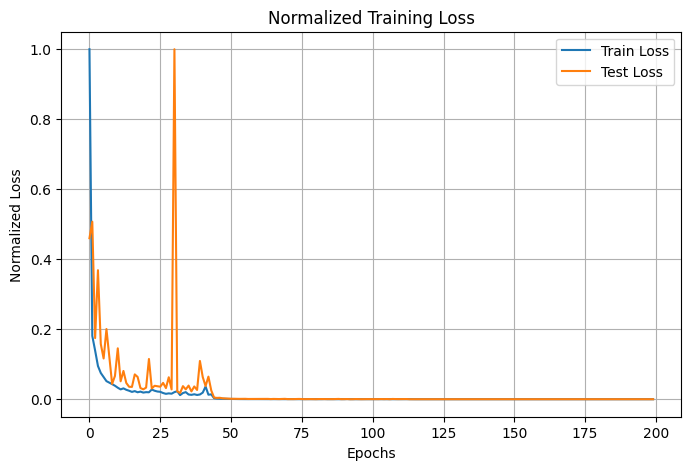

Fold 3
Epoch 0 | Loss train: 3.346758 | Loss test: 0.448928 | lr = 0.01
Epoch 10 | Loss train: 0.076463 | Loss test: 0.158023 | lr = 0.01
Epoch 20 | Loss train: 0.052407 | Loss test: 0.050139 | lr = 0.01
Epoch 30 | Loss train: 0.031297 | Loss test: 0.048194 | lr = 0.01
Epoch 40 | Loss train: 0.022318 | Loss test: 0.036751 | lr = 0.01
Epoch 50 | Loss train: 0.025044 | Loss test: 0.041758 | lr = 0.01
Epoch 60 | Loss train: 0.000885 | Loss test: 0.000704 | lr = 0.001
Epoch 70 | Loss train: 0.000225 | Loss test: 0.000374 | lr = 0.001
Epoch 80 | Loss train: 0.000581 | Loss test: 0.000524 | lr = 0.001
Epoch 90 | Loss train: 0.000158 | Loss test: 0.000196 | lr = 0.001
Epoch 100 | Loss train: 0.000091 | Loss test: 0.000050 | lr = 0.001
Epoch 110 | Loss train: 0.000003 | Loss test: 0.000008 | lr = 0.0001
Epoch 120 | Loss train: 0.000001 | Loss test: 0.000005 | lr = 0.0001
Epoch 130 | Loss train: 0.000005 | Loss test: 0.000005 | lr = 0.0001
Epoch 140 | Loss train: 0.000000 | Loss test: 0.000003 

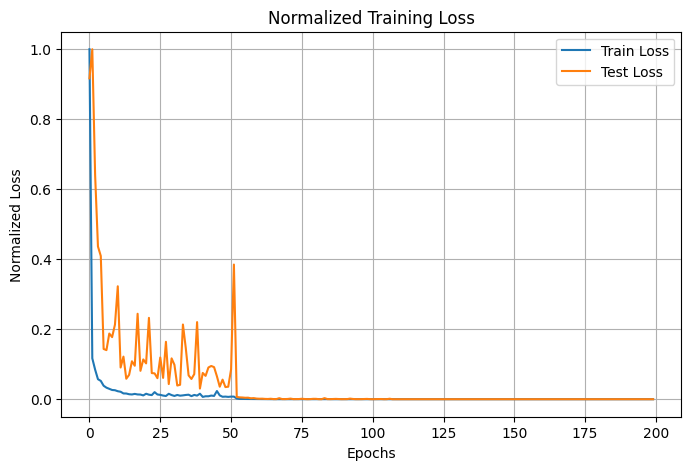

Fold 4
Epoch 0 | Loss train: 1.392756 | Loss test: 1.600980 | lr = 0.01
Epoch 10 | Loss train: 0.082727 | Loss test: 0.066329 | lr = 0.01
Epoch 20 | Loss train: 0.043524 | Loss test: 0.034572 | lr = 0.01
Epoch 30 | Loss train: 0.054774 | Loss test: 0.227036 | lr = 0.01
Epoch 40 | Loss train: 0.003233 | Loss test: 0.003719 | lr = 0.001
Epoch 50 | Loss train: 0.000840 | Loss test: 0.000527 | lr = 0.001
Epoch 60 | Loss train: 0.000378 | Loss test: 0.000558 | lr = 0.001
Epoch 70 | Loss train: 0.000803 | Loss test: 0.000397 | lr = 0.001
Epoch 80 | Loss train: 0.000489 | Loss test: 0.000365 | lr = 0.001
Epoch 90 | Loss train: 0.000023 | Loss test: 0.000020 | lr = 0.0001
Epoch 100 | Loss train: 0.000009 | Loss test: 0.000010 | lr = 0.0001
Epoch 110 | Loss train: 0.000005 | Loss test: 0.000009 | lr = 0.0001
Epoch 120 | Loss train: 0.000009 | Loss test: 0.000004 | lr = 0.0001
Epoch 130 | Loss train: 0.000007 | Loss test: 0.000011 | lr = 0.0001
Epoch 140 | Loss train: 0.000000 | Loss test: 0.000

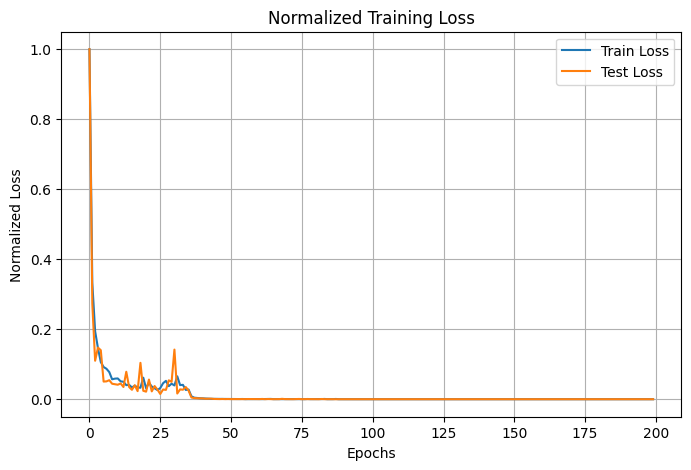

Fold 5
Epoch 0 | Loss train: 2.064898 | Loss test: 0.760475 | lr = 0.01
Epoch 10 | Loss train: 0.079551 | Loss test: 0.167354 | lr = 0.01
Epoch 20 | Loss train: 0.049136 | Loss test: 0.069151 | lr = 0.01
Epoch 30 | Loss train: 0.051816 | Loss test: 0.148807 | lr = 0.01
Epoch 40 | Loss train: 0.079675 | Loss test: 0.044488 | lr = 0.01
Epoch 50 | Loss train: 0.032628 | Loss test: 0.097162 | lr = 0.01
Epoch 60 | Loss train: 0.029293 | Loss test: 0.026138 | lr = 0.01
Epoch 70 | Loss train: 0.001017 | Loss test: 0.000978 | lr = 0.001
Epoch 80 | Loss train: 0.000379 | Loss test: 0.000182 | lr = 0.001
Epoch 90 | Loss train: 0.000244 | Loss test: 0.000292 | lr = 0.001
Epoch 100 | Loss train: 0.000235 | Loss test: 0.000565 | lr = 0.001
Epoch 110 | Loss train: 0.000154 | Loss test: 0.000328 | lr = 0.001
Epoch 120 | Loss train: 0.000109 | Loss test: 0.000203 | lr = 0.001
Epoch 130 | Loss train: 0.000029 | Loss test: 0.000013 | lr = 0.001
Epoch 140 | Loss train: 0.000002 | Loss test: 0.000003 | lr

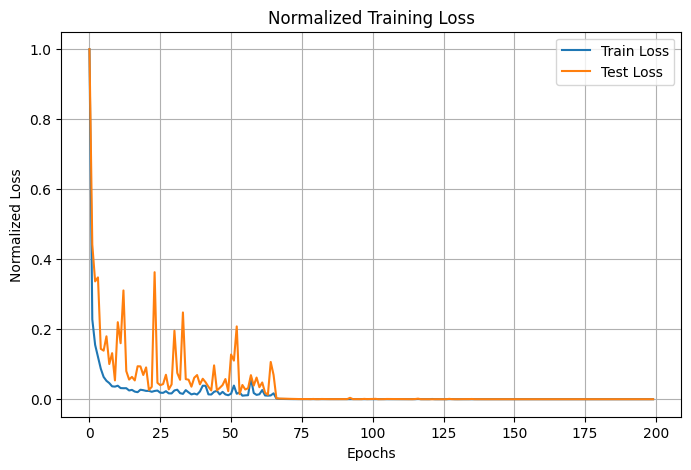

Cross-Validation finished with mean error across 5 subsets = 7.0135855537500905e-06, evaluating final model...
Epoch 0 | Loss train: 1.645715 | lr = 0.01
Epoch 10 | Loss train: 0.054686 | lr = 0.01
Epoch 20 | Loss train: 0.044302 | lr = 0.01
Epoch 30 | Loss train: 0.031593 | lr = 0.01
Epoch 40 | Loss train: 0.027384 | lr = 0.01
Epoch 50 | Loss train: 0.039528 | lr = 0.01
Epoch 60 | Loss train: 0.025373 | lr = 0.01
Epoch 70 | Loss train: 0.043432 | lr = 0.001
Epoch 80 | Loss train: 0.000308 | lr = 0.001
Epoch 90 | Loss train: 0.000383 | lr = 0.001
Epoch 100 | Loss train: 0.000204 | lr = 0.001
Epoch 110 | Loss train: 0.000001 | lr = 0.0001
Epoch 120 | Loss train: 0.000000 | lr = 0.0001
Epoch 130 | Loss train: 0.000003 | lr = 1e-05
Epoch 140 | Loss train: 0.000000 | lr = 1e-05
Epoch 150 | Loss train: 0.000000 | lr = 1e-05
Epoch 160 | Loss train: 0.000000 | lr = 1e-05
Epoch 170 | Loss train: 0.000000 | lr = 1e-05
Epoch 180 | Loss train: 0.000000 | lr = 1e-05
Epoch 190 | Loss train: 0.00000

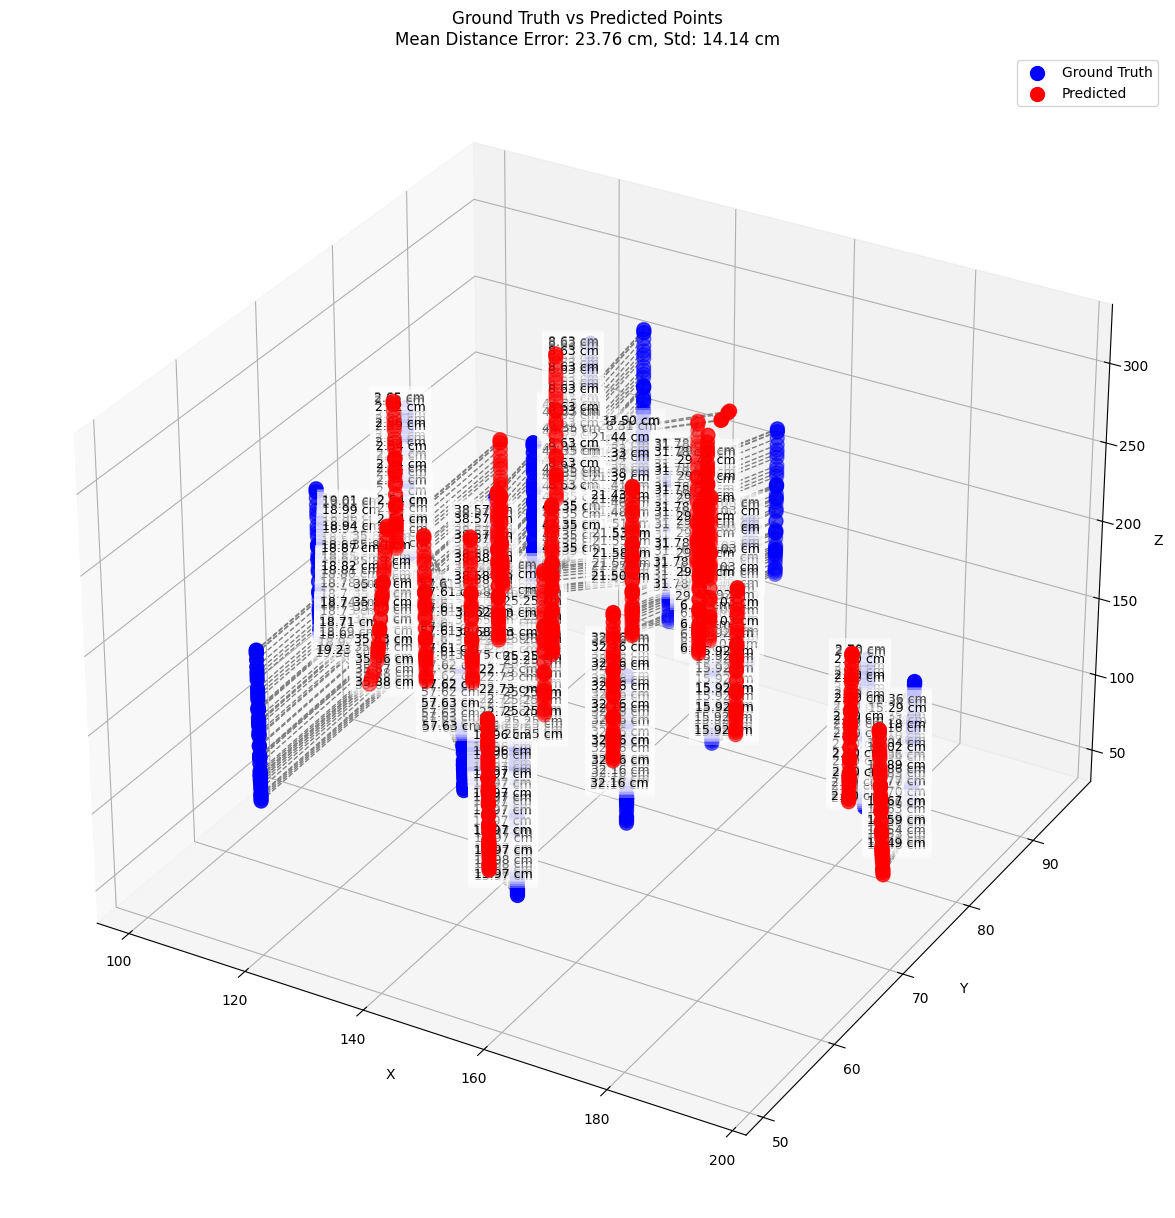

In [70]:
loss_fn = nn.MSELoss()
optim = torch.optim.Adam
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len, 'hidden_units': 128}
early_stop_params = {'patience': 90, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 5
epoch = 200

leakyrelu = cross_validation(cv_train_data,cv_train_labels,cv_test_data,cv_test_labels, n_splits=num_splits, model= LeakyReLUModel, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device)

In [ ]:
leakyrelu

{'model_name': 'LeakyReLUModel',
 'mean_distance_error_cm': 18.610185623168945,
 'std': 8.957880973815918}

#### +1 Layer

Μιας και βλέπουμε ότι τα καλύτερα αποτελέσματα τα δίνει το μοντέλο με συνάρτηση ενεργοποίησης LeakyReLU , θα δοκιμάσουμε να βάλουμε άλλο ένα layer για να δούμε πως θα επηρεαστουν τα αποτελέσματα.

In [ ]:
class LeakyReLUModel4(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 64):
        super(LeakyReLUModel4, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Fold 1
Epoch 0 | Loss train: 4.927721 | Loss test: 2.715819 | lr = 0.01
Epoch 10 | Loss train: 0.626251 | Loss test: 0.372799 | lr = 0.01
Epoch 20 | Loss train: 0.522213 | Loss test: 0.429344 | lr = 0.01
Epoch 30 | Loss train: 0.423748 | Loss test: 0.317433 | lr = 0.01
Epoch 40 | Loss train: 0.371016 | Loss test: 0.318825 | lr = 0.01
Epoch 50 | Loss train: 0.373426 | Loss test: 0.358634 | lr = 0.01
Epoch 60 | Loss train: 0.393394 | Loss test: 0.252432 | lr = 0.001
Epoch 70 | Loss train: 0.430342 | Loss test: 0.251070 | lr = 0.0001
Epoch 80 | Loss train: 0.302765 | Loss test: 0.250059 | lr = 0.0001
Epoch 90 | Loss train: 0.292252 | Loss test: 0.255943 | lr = 0.0001
Epoch 100 | Loss train: 0.367542 | Loss test: 0.260887 | lr = 0.0001
Epoch 110 | Loss train: 0.359391 | Loss test: 0.260585 | lr = 0.0001
Epoch 120 | Loss train: 0.328209 | Loss test: 0.258745 | lr = 1e-05
Epoch 130 | Loss train: 0.278626 | Loss test: 0.260898 | lr = 1e-05
Epoch 140 | Loss train: 0.315580 | Loss test: 0.26258

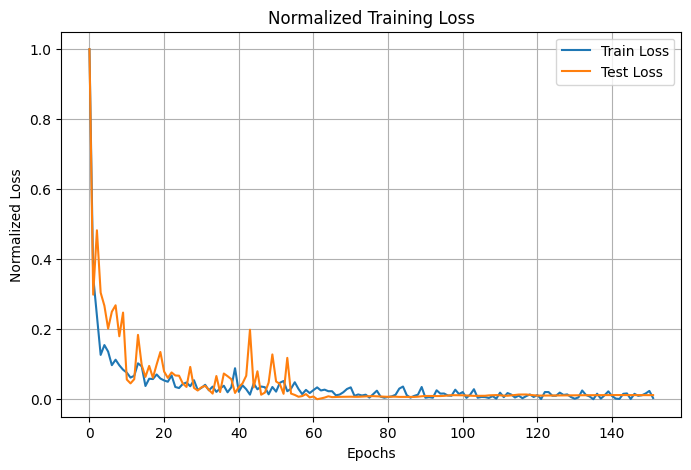

Fold 2
Epoch 0 | Loss train: 3.527070 | Loss test: 1.908844 | lr = 0.01
Epoch 10 | Loss train: 0.555047 | Loss test: 0.874448 | lr = 0.01
Epoch 20 | Loss train: 0.518371 | Loss test: 1.105475 | lr = 0.01
Epoch 30 | Loss train: 0.434091 | Loss test: 0.865525 | lr = 0.001
Epoch 40 | Loss train: 0.409897 | Loss test: 0.841600 | lr = 0.001
Epoch 50 | Loss train: 0.408725 | Loss test: 0.805757 | lr = 0.001
Epoch 60 | Loss train: 0.397595 | Loss test: 0.811536 | lr = 0.0001
Epoch 70 | Loss train: 0.425184 | Loss test: 0.798759 | lr = 0.0001
Epoch 80 | Loss train: 0.382810 | Loss test: 0.807877 | lr = 1e-05
Epoch 90 | Loss train: 0.354322 | Loss test: 0.802916 | lr = 1e-05
Epoch 100 | Loss train: 0.416691 | Loss test: 0.801499 | lr = 1e-05
Epoch 110 | Loss train: 0.386043 | Loss test: 0.800013 | lr = 1e-05
Early stopping at epoch 118
Loaded best model from temp_model.pth


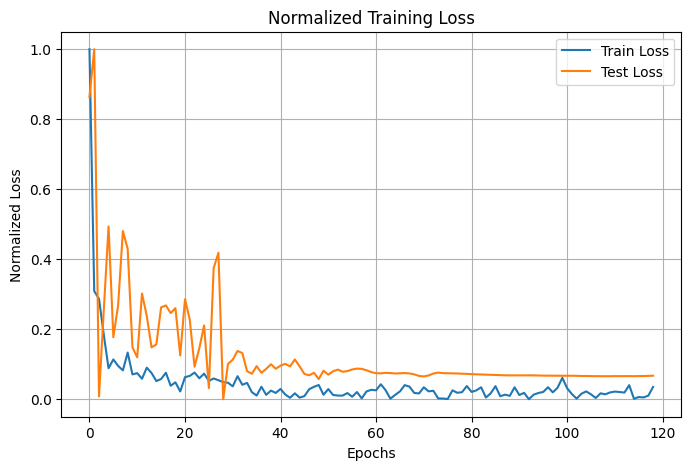

Fold 3
Epoch 0 | Loss train: 5.192064 | Loss test: 6.587009 | lr = 0.01
Epoch 10 | Loss train: 0.653352 | Loss test: 0.368170 | lr = 0.01
Epoch 20 | Loss train: 0.693900 | Loss test: 0.602202 | lr = 0.01
Epoch 30 | Loss train: 0.493916 | Loss test: 0.320993 | lr = 0.01
Epoch 40 | Loss train: 0.584185 | Loss test: 0.405479 | lr = 0.01
Epoch 50 | Loss train: 0.335480 | Loss test: 0.406421 | lr = 0.01
Epoch 60 | Loss train: 0.370507 | Loss test: 1.674583 | lr = 0.01
Epoch 70 | Loss train: 0.325535 | Loss test: 0.299830 | lr = 0.01
Epoch 80 | Loss train: 0.238295 | Loss test: 0.210185 | lr = 0.001
Epoch 90 | Loss train: 0.155304 | Loss test: 0.223817 | lr = 0.001
Epoch 100 | Loss train: 0.204095 | Loss test: 0.212614 | lr = 0.001
Epoch 110 | Loss train: 0.128280 | Loss test: 0.184268 | lr = 0.001
Epoch 120 | Loss train: 0.108342 | Loss test: 0.187874 | lr = 0.001
Epoch 130 | Loss train: 0.095656 | Loss test: 0.206426 | lr = 0.001
Epoch 140 | Loss train: 0.082282 | Loss test: 0.215334 | lr 

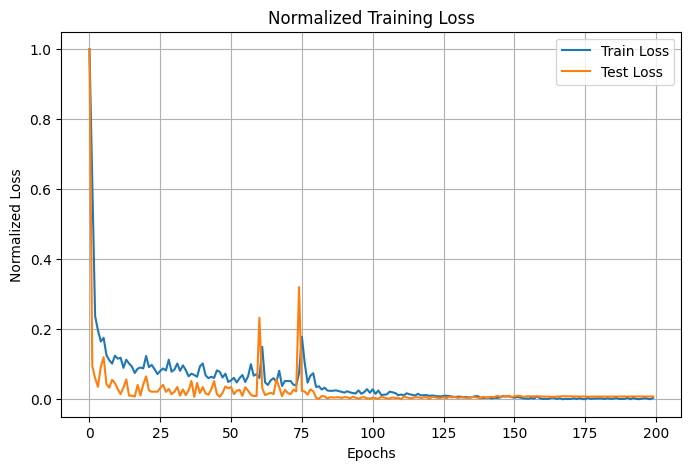

Fold 4
Epoch 0 | Loss train: 6.478870 | Loss test: 6.016291 | lr = 0.01
Epoch 10 | Loss train: 0.515253 | Loss test: 0.319969 | lr = 0.01
Epoch 20 | Loss train: 0.498821 | Loss test: 0.256343 | lr = 0.01
Epoch 30 | Loss train: 0.451619 | Loss test: 0.691879 | lr = 0.01
Epoch 40 | Loss train: 0.282262 | Loss test: 0.271134 | lr = 0.001
Epoch 50 | Loss train: 0.268518 | Loss test: 0.333190 | lr = 0.001
Epoch 60 | Loss train: 0.180775 | Loss test: 0.602341 | lr = 0.001
Epoch 70 | Loss train: 0.144746 | Loss test: 0.221432 | lr = 0.001
Epoch 80 | Loss train: 0.116962 | Loss test: 0.236651 | lr = 0.001
Epoch 90 | Loss train: 0.117537 | Loss test: 0.331546 | lr = 0.001
Epoch 100 | Loss train: 0.076634 | Loss test: 0.292861 | lr = 0.001
Epoch 110 | Loss train: 0.066979 | Loss test: 0.196575 | lr = 0.001
Epoch 120 | Loss train: 0.083471 | Loss test: 0.194261 | lr = 0.001
Epoch 130 | Loss train: 0.055183 | Loss test: 0.212114 | lr = 0.001
Epoch 140 | Loss train: 0.061269 | Loss test: 0.233450 |

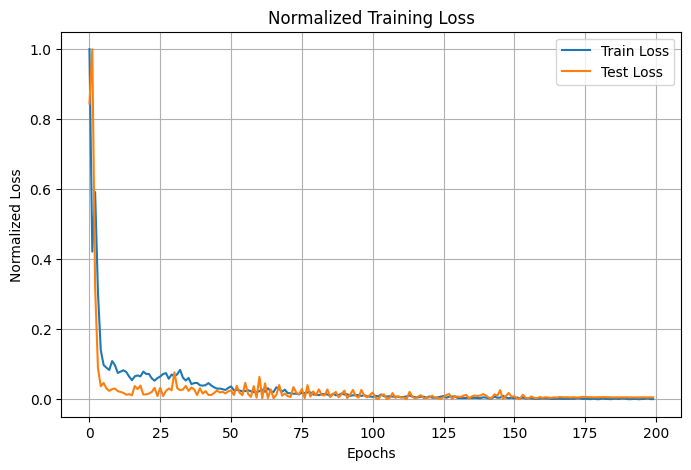

Fold 5
Epoch 0 | Loss train: 3.274005 | Loss test: 1.613668 | lr = 0.01
Epoch 10 | Loss train: 0.577472 | Loss test: 0.869380 | lr = 0.01
Epoch 20 | Loss train: 0.403510 | Loss test: 1.264187 | lr = 0.01
Epoch 30 | Loss train: 0.472916 | Loss test: 0.972311 | lr = 0.01
Epoch 40 | Loss train: 0.378666 | Loss test: 0.872076 | lr = 0.01
Epoch 50 | Loss train: 0.323092 | Loss test: 0.895588 | lr = 0.01
Epoch 60 | Loss train: 0.489505 | Loss test: 1.247019 | lr = 0.01
Epoch 70 | Loss train: 0.158910 | Loss test: 1.018898 | lr = 0.001
Epoch 80 | Loss train: 0.131811 | Loss test: 0.856221 | lr = 0.001
Epoch 90 | Loss train: 0.116646 | Loss test: 1.043941 | lr = 0.001
Epoch 100 | Loss train: 0.077042 | Loss test: 0.746306 | lr = 0.001
Epoch 110 | Loss train: 0.064485 | Loss test: 0.731739 | lr = 0.001
Epoch 120 | Loss train: 0.057587 | Loss test: 0.638683 | lr = 0.001
Epoch 130 | Loss train: 0.051526 | Loss test: 0.665689 | lr = 0.001
Epoch 140 | Loss train: 0.050319 | Loss test: 0.728207 | lr

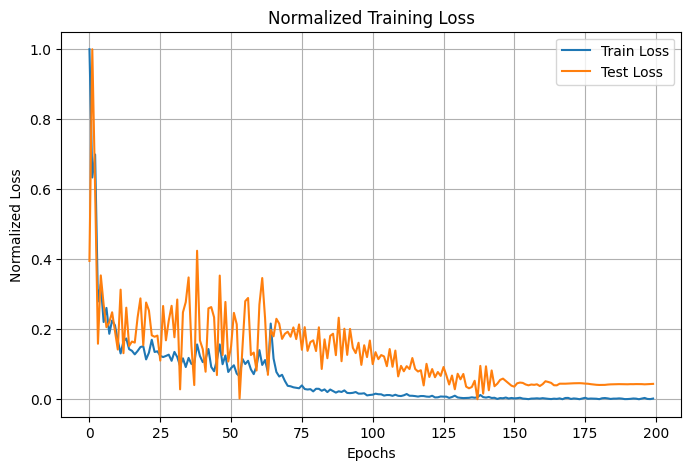

Cross-Validation finished with mean error across 5 subsets = 0.34746508076786997, evaluating final model...
Epoch 0 | Loss train: 5.847335 | lr = 0.01
Epoch 10 | Loss train: 0.782309 | lr = 0.01
Epoch 20 | Loss train: 0.476305 | lr = 0.01
Epoch 30 | Loss train: 0.534707 | lr = 0.01
Epoch 40 | Loss train: 0.414539 | lr = 0.001
Epoch 50 | Loss train: 0.319749 | lr = 0.001
Epoch 60 | Loss train: 0.255662 | lr = 0.001
Epoch 70 | Loss train: 0.167417 | lr = 0.001
Epoch 80 | Loss train: 0.118535 | lr = 0.001
Epoch 90 | Loss train: 0.176462 | lr = 0.001
Epoch 100 | Loss train: 0.109417 | lr = 0.001
Epoch 110 | Loss train: 0.087604 | lr = 0.001
Epoch 120 | Loss train: 0.090904 | lr = 0.001
Epoch 130 | Loss train: 0.070551 | lr = 0.001
Epoch 140 | Loss train: 0.064538 | lr = 0.001
Epoch 150 | Loss train: 0.070993 | lr = 0.001
Epoch 160 | Loss train: 0.049345 | lr = 0.001
Epoch 170 | Loss train: 0.042408 | lr = 0.0001
Epoch 180 | Loss train: 0.037187 | lr = 0.0001
Epoch 190 | Loss train: 0.03352

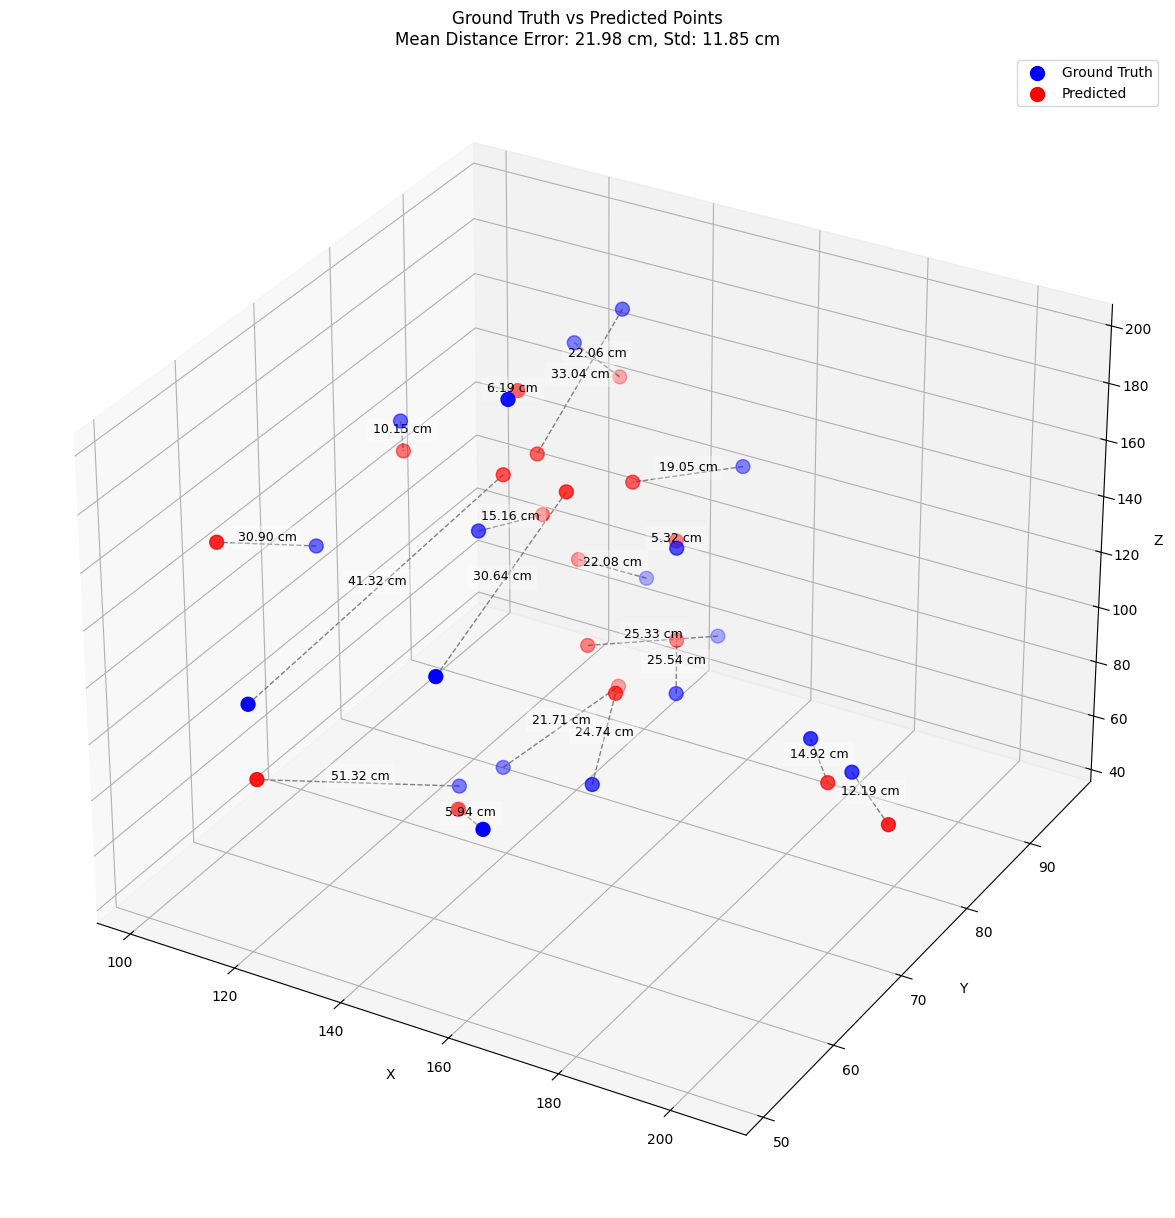

In [ ]:
loss_fn = nn.MSELoss()
optim = torch.optim.Adam
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len, 'hidden_units': 64}
early_stop_params = {'patience': 90, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 5
epoch = 200

leakyrelu_4 = cross_validation(cv_train_data,cv_train_labels,cv_test_data,cv_test_labels, n_splits=num_splits, model= LeakyReLUModel4, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device)

Παρατηρούμε ότι η επίδοση του μοντέλου δεν καλυτέρεψε, άρα δεν χρειάζεται να προσθέσουμε και άλλα layers.

#### -1 Layer

In [ ]:
class LeakyReLUModel2(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 64):
        super(LeakyReLUModel2, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Fold 1
Epoch 0 | Loss train: 201.456794 | Loss test: 6.709726 | lr = 0.01
Epoch 10 | Loss train: 3.488226 | Loss test: 2.959324 | lr = 0.01
Epoch 20 | Loss train: 1.212455 | Loss test: 2.157965 | lr = 0.01
Epoch 30 | Loss train: 0.724139 | Loss test: 0.442084 | lr = 0.01
Epoch 40 | Loss train: 0.547652 | Loss test: 0.368068 | lr = 0.01
Epoch 50 | Loss train: 0.609813 | Loss test: 0.454077 | lr = 0.01
Epoch 60 | Loss train: 0.749395 | Loss test: 0.778876 | lr = 0.01
Epoch 70 | Loss train: 0.389232 | Loss test: 0.243942 | lr = 0.001
Epoch 80 | Loss train: 0.270729 | Loss test: 0.228738 | lr = 0.001
Epoch 90 | Loss train: 0.235699 | Loss test: 0.267471 | lr = 0.001
Epoch 100 | Loss train: 0.276090 | Loss test: 0.220745 | lr = 0.001
Epoch 110 | Loss train: 0.232156 | Loss test: 0.250250 | lr = 0.001
Epoch 120 | Loss train: 0.197612 | Loss test: 0.228255 | lr = 0.001
Epoch 130 | Loss train: 0.189478 | Loss test: 0.198668 | lr = 0.001
Epoch 140 | Loss train: 0.148924 | Loss test: 0.176918 | 

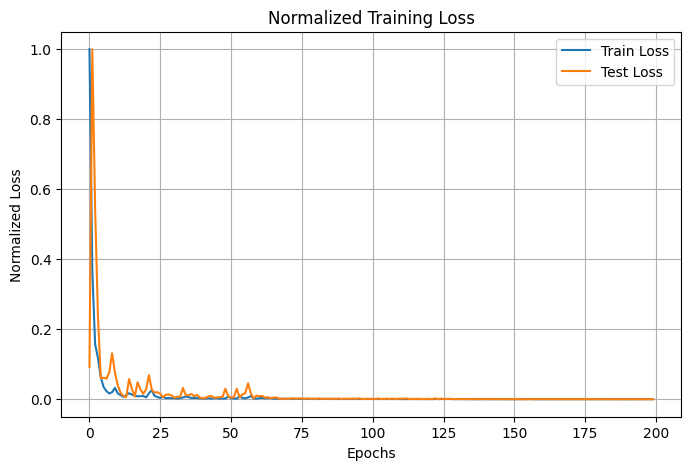

Fold 2
Epoch 0 | Loss train: 26.563505 | Loss test: 20.726482 | lr = 0.01
Epoch 10 | Loss train: 0.954902 | Loss test: 2.664751 | lr = 0.01
Epoch 20 | Loss train: 0.973409 | Loss test: 0.673189 | lr = 0.01
Epoch 30 | Loss train: 0.906887 | Loss test: 1.143913 | lr = 0.01
Epoch 40 | Loss train: 0.402876 | Loss test: 0.782998 | lr = 0.001
Epoch 50 | Loss train: 0.310866 | Loss test: 0.732222 | lr = 0.001
Epoch 60 | Loss train: 0.251108 | Loss test: 0.524273 | lr = 0.001
Epoch 70 | Loss train: 0.252457 | Loss test: 0.785296 | lr = 0.001
Epoch 80 | Loss train: 0.227985 | Loss test: 0.546832 | lr = 0.001
Epoch 90 | Loss train: 0.190613 | Loss test: 0.279230 | lr = 0.001
Epoch 100 | Loss train: 0.191537 | Loss test: 0.372124 | lr = 0.0001
Epoch 110 | Loss train: 0.157900 | Loss test: 0.375102 | lr = 0.0001
Epoch 120 | Loss train: 0.126517 | Loss test: 0.359482 | lr = 0.0001
Epoch 130 | Loss train: 0.136064 | Loss test: 0.358634 | lr = 1e-05
Epoch 140 | Loss train: 0.136646 | Loss test: 0.366

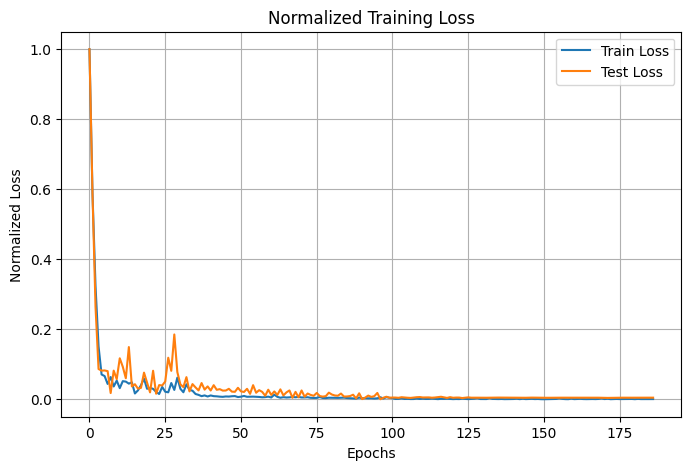

Fold 3
Epoch 0 | Loss train: 161.706882 | Loss test: 14.036527 | lr = 0.01
Epoch 10 | Loss train: 2.024413 | Loss test: 0.805805 | lr = 0.01
Epoch 20 | Loss train: 2.094082 | Loss test: 1.337714 | lr = 0.01
Epoch 30 | Loss train: 0.608205 | Loss test: 0.449226 | lr = 0.01
Epoch 40 | Loss train: 0.743839 | Loss test: 0.458767 | lr = 0.01
Epoch 50 | Loss train: 0.446523 | Loss test: 0.798870 | lr = 0.01
Epoch 60 | Loss train: 0.526058 | Loss test: 0.764549 | lr = 0.01
Epoch 70 | Loss train: 0.378560 | Loss test: 0.194196 | lr = 0.001
Epoch 80 | Loss train: 0.173110 | Loss test: 0.184467 | lr = 0.001
Epoch 90 | Loss train: 0.186766 | Loss test: 0.198490 | lr = 0.001
Epoch 100 | Loss train: 0.188163 | Loss test: 0.238082 | lr = 0.001
Epoch 110 | Loss train: 0.143197 | Loss test: 0.229204 | lr = 0.001
Epoch 120 | Loss train: 0.144562 | Loss test: 0.226516 | lr = 0.001
Epoch 130 | Loss train: 0.134848 | Loss test: 0.226085 | lr = 0.001
Epoch 140 | Loss train: 0.098841 | Loss test: 0.219703 |

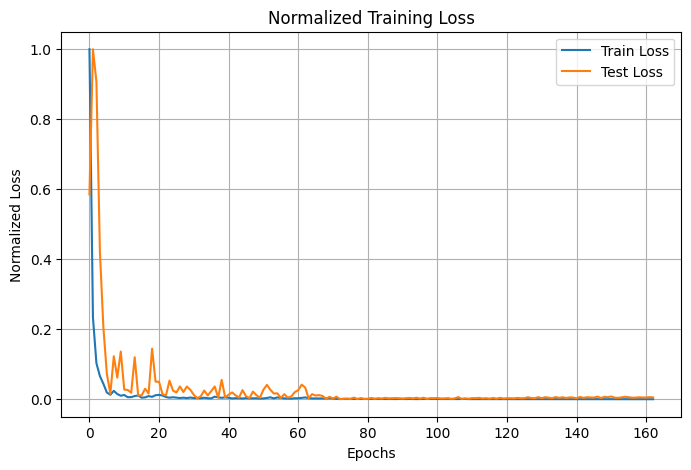

Fold 4
Epoch 0 | Loss train: 177.898055 | Loss test: 4.763237 | lr = 0.01
Epoch 10 | Loss train: 2.230372 | Loss test: 1.332792 | lr = 0.01
Epoch 20 | Loss train: 0.751363 | Loss test: 1.483599 | lr = 0.01
Epoch 30 | Loss train: 0.775246 | Loss test: 1.438005 | lr = 0.01
Epoch 40 | Loss train: 0.285977 | Loss test: 0.226884 | lr = 0.001
Epoch 50 | Loss train: 0.272968 | Loss test: 0.255617 | lr = 0.001
Epoch 60 | Loss train: 0.220520 | Loss test: 0.358251 | lr = 0.001
Epoch 70 | Loss train: 0.397574 | Loss test: 0.347949 | lr = 0.001
Epoch 80 | Loss train: 0.170425 | Loss test: 0.338307 | lr = 0.001
Epoch 90 | Loss train: 0.189402 | Loss test: 0.366078 | lr = 0.001
Epoch 100 | Loss train: 0.132209 | Loss test: 0.408560 | lr = 0.001
Epoch 110 | Loss train: 0.201799 | Loss test: 0.284409 | lr = 0.001
Epoch 120 | Loss train: 0.123575 | Loss test: 0.248312 | lr = 0.0001
Epoch 130 | Loss train: 0.098433 | Loss test: 0.315093 | lr = 0.0001
Epoch 140 | Loss train: 0.101328 | Loss test: 0.3281

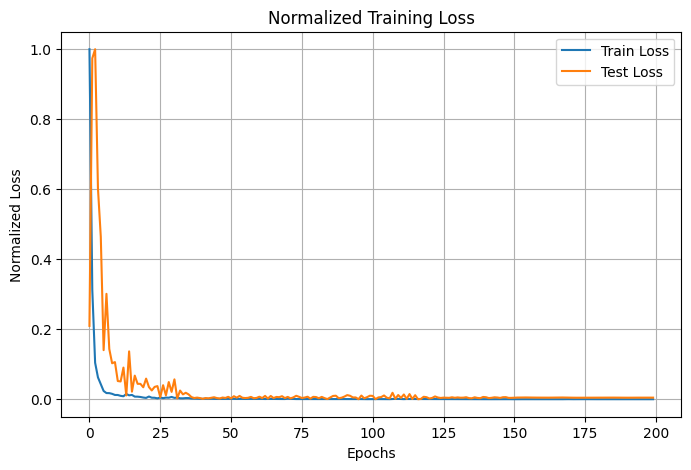

Fold 5
Epoch 0 | Loss train: 139.258283 | Loss test: 4.852412 | lr = 0.01
Epoch 10 | Loss train: 1.446975 | Loss test: 1.754091 | lr = 0.01
Epoch 20 | Loss train: 1.544662 | Loss test: 1.683102 | lr = 0.01
Epoch 30 | Loss train: 0.627264 | Loss test: 0.819744 | lr = 0.01
Epoch 40 | Loss train: 0.694001 | Loss test: 0.838879 | lr = 0.01
Epoch 50 | Loss train: 0.582894 | Loss test: 0.788346 | lr = 0.001
Epoch 60 | Loss train: 0.281849 | Loss test: 0.855425 | lr = 0.001
Epoch 70 | Loss train: 0.250449 | Loss test: 0.667183 | lr = 0.001
Epoch 80 | Loss train: 0.207370 | Loss test: 0.885857 | lr = 0.001
Epoch 90 | Loss train: 0.171712 | Loss test: 0.608498 | lr = 0.001
Epoch 100 | Loss train: 0.171972 | Loss test: 0.769546 | lr = 0.001
Epoch 110 | Loss train: 0.135706 | Loss test: 0.680277 | lr = 0.001
Epoch 120 | Loss train: 0.124530 | Loss test: 0.621773 | lr = 0.001
Epoch 130 | Loss train: 0.135736 | Loss test: 0.788121 | lr = 0.001
Epoch 140 | Loss train: 0.120621 | Loss test: 0.506797 

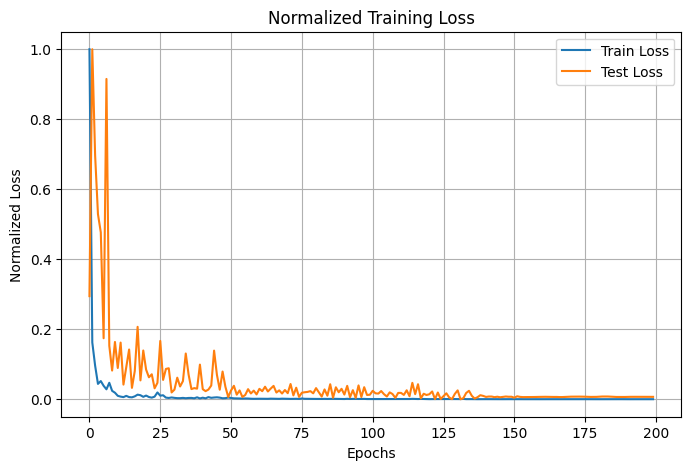

Cross-Validation finished with mean error across 5 subsets = 0.23840066250413655, evaluating final model...
Epoch 0 | Loss train: 154.441662 | lr = 0.01
Epoch 10 | Loss train: 1.175936 | lr = 0.01
Epoch 20 | Loss train: 1.070132 | lr = 0.01
Epoch 30 | Loss train: 0.599479 | lr = 0.01
Epoch 40 | Loss train: 0.610559 | lr = 0.01
Epoch 50 | Loss train: 0.727460 | lr = 0.01
Epoch 60 | Loss train: 0.351286 | lr = 0.001
Epoch 70 | Loss train: 0.247440 | lr = 0.001
Epoch 80 | Loss train: 0.215981 | lr = 0.001
Epoch 90 | Loss train: 0.278083 | lr = 0.001
Epoch 100 | Loss train: 0.194405 | lr = 0.001
Epoch 110 | Loss train: 0.147650 | lr = 0.0001
Epoch 120 | Loss train: 0.139252 | lr = 0.0001
Epoch 130 | Loss train: 0.159097 | lr = 0.0001
Epoch 140 | Loss train: 0.133258 | lr = 0.0001
Epoch 150 | Loss train: 0.146321 | lr = 1e-05
Epoch 160 | Loss train: 0.129097 | lr = 1e-05
Epoch 170 | Loss train: 0.138730 | lr = 1e-05
Epoch 180 | Loss train: 0.139177 | lr = 1e-05
Epoch 190 | Loss train: 0.138

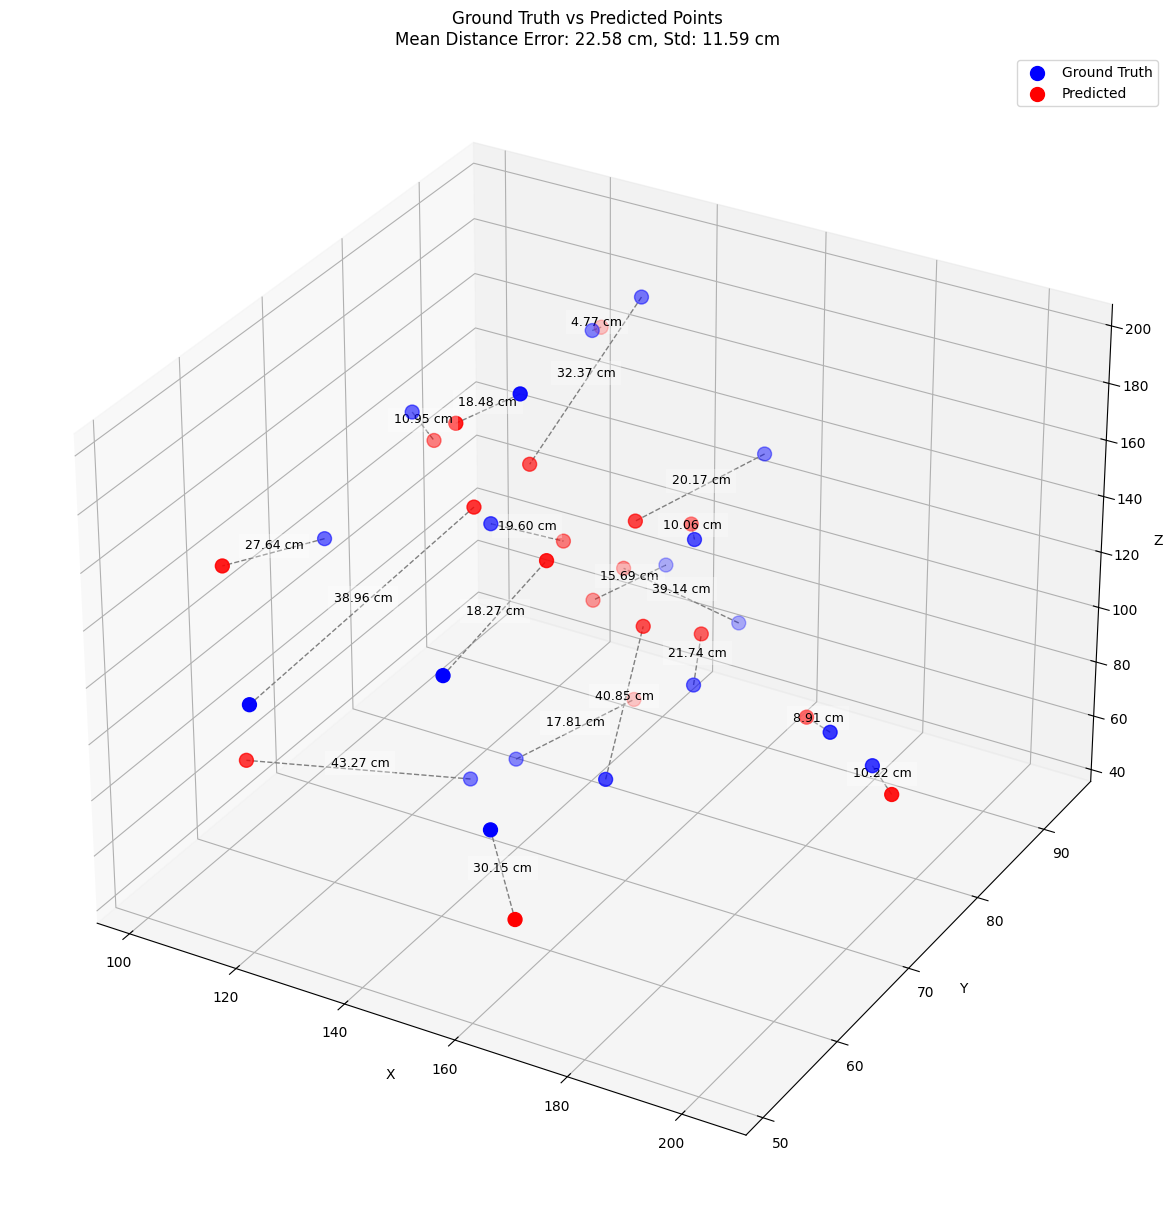

In [ ]:
loss_fn = nn.MSELoss()
optim = torch.optim.Adam
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len, 'hidden_units': 64}
early_stop_params = {'patience': 90, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 5
epoch = 200

leakyrelu_2 = cross_validation(cv_train_data,cv_train_labels,cv_test_data,cv_test_labels, n_splits=num_splits, model= LeakyReLUModel2, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device)

#### -1 Layer rmsprop

In [ ]:
class LeakyReLUModel2_RMS(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 64):
        super(LeakyReLUModel2_RMS, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Fold 1
Epoch 0 | Loss train: 50513.860973 | Loss test: 2276.606201 | lr = 0.01
Epoch 10 | Loss train: 343.496551 | Loss test: 9.780192 | lr = 0.01
Epoch 20 | Loss train: 11.037575 | Loss test: 3.620137 | lr = 0.01
Epoch 30 | Loss train: 4.314095 | Loss test: 1.509529 | lr = 0.01
Epoch 40 | Loss train: 2.808985 | Loss test: 1.275923 | lr = 0.01
Epoch 50 | Loss train: 0.476293 | Loss test: 0.376543 | lr = 0.001
Epoch 60 | Loss train: 0.439727 | Loss test: 0.365472 | lr = 0.001
Epoch 70 | Loss train: 0.414914 | Loss test: 0.306764 | lr = 0.001
Epoch 80 | Loss train: 0.309888 | Loss test: 0.347485 | lr = 0.001
Epoch 90 | Loss train: 0.285288 | Loss test: 0.284836 | lr = 0.001
Epoch 100 | Loss train: 0.283304 | Loss test: 0.206489 | lr = 0.0001
Epoch 110 | Loss train: 0.214227 | Loss test: 0.270144 | lr = 0.0001
Epoch 120 | Loss train: 0.224994 | Loss test: 0.261190 | lr = 0.0001
Epoch 130 | Loss train: 0.173657 | Loss test: 0.247017 | lr = 0.0001
Epoch 140 | Loss train: 0.198445 | Loss tes

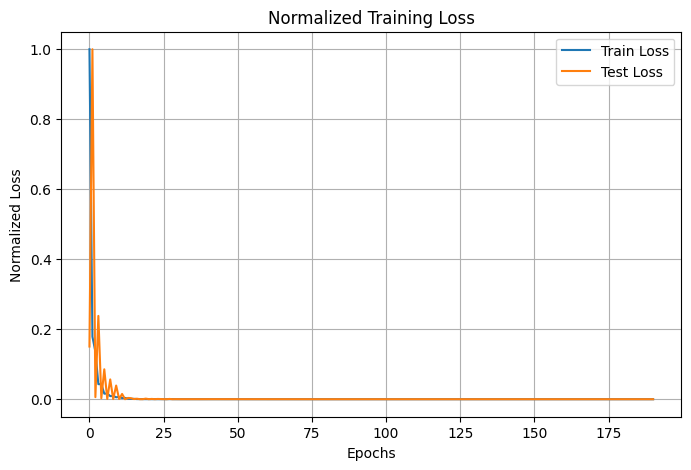

Fold 2
Epoch 0 | Loss train: 31388.002956 | Loss test: 3423.266479 | lr = 0.01
Epoch 10 | Loss train: 92.210804 | Loss test: 71.467354 | lr = 0.01
Epoch 20 | Loss train: 17.987052 | Loss test: 3.329960 | lr = 0.01
Epoch 30 | Loss train: 4.439297 | Loss test: 6.491785 | lr = 0.01
Epoch 40 | Loss train: 2.351495 | Loss test: 9.767027 | lr = 0.01
Epoch 50 | Loss train: 0.510248 | Loss test: 1.207284 | lr = 0.001
Epoch 60 | Loss train: 0.492289 | Loss test: 0.780669 | lr = 0.001
Epoch 70 | Loss train: 0.439663 | Loss test: 1.118633 | lr = 0.001
Epoch 80 | Loss train: 0.393514 | Loss test: 0.571535 | lr = 0.001
Epoch 90 | Loss train: 0.260314 | Loss test: 0.716142 | lr = 0.0001
Epoch 100 | Loss train: 0.317732 | Loss test: 0.669631 | lr = 0.0001
Epoch 110 | Loss train: 0.247474 | Loss test: 0.706093 | lr = 1e-05
Epoch 120 | Loss train: 0.226473 | Loss test: 0.692309 | lr = 1e-05
Epoch 130 | Loss train: 0.275659 | Loss test: 0.678031 | lr = 1e-05
Epoch 140 | Loss train: 0.284004 | Loss test:

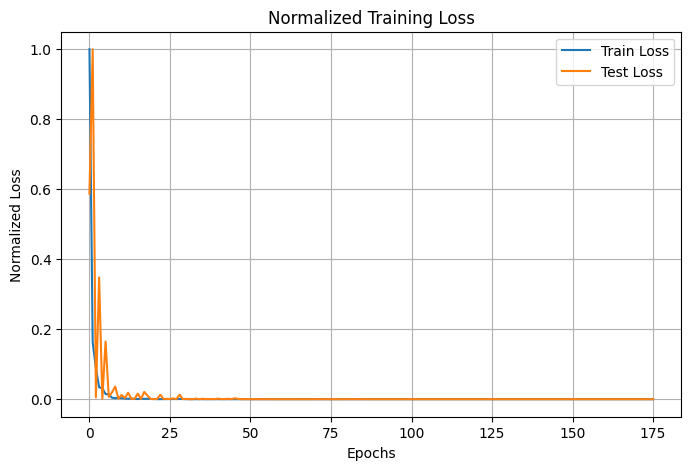

Fold 3
Epoch 0 | Loss train: 29590.110662 | Loss test: 1394.022583 | lr = 0.01
Epoch 10 | Loss train: 108.669650 | Loss test: 45.236624 | lr = 0.01
Epoch 20 | Loss train: 17.173016 | Loss test: 30.221869 | lr = 0.01
Epoch 30 | Loss train: 2.864545 | Loss test: 2.089219 | lr = 0.01
Epoch 40 | Loss train: 3.246664 | Loss test: 2.859402 | lr = 0.01
Epoch 50 | Loss train: 1.945350 | Loss test: 1.499649 | lr = 0.001
Epoch 60 | Loss train: 0.480318 | Loss test: 0.277475 | lr = 0.001
Epoch 70 | Loss train: 0.398038 | Loss test: 0.270010 | lr = 0.001
Epoch 80 | Loss train: 0.292938 | Loss test: 0.265178 | lr = 0.001
Epoch 90 | Loss train: 0.301679 | Loss test: 0.338660 | lr = 0.001
Epoch 100 | Loss train: 0.306877 | Loss test: 0.219226 | lr = 0.001
Epoch 110 | Loss train: 0.240510 | Loss test: 0.197239 | lr = 0.001
Epoch 120 | Loss train: 0.235063 | Loss test: 0.329015 | lr = 0.001
Epoch 130 | Loss train: 0.200322 | Loss test: 0.205963 | lr = 0.001
Epoch 140 | Loss train: 0.221493 | Loss test:

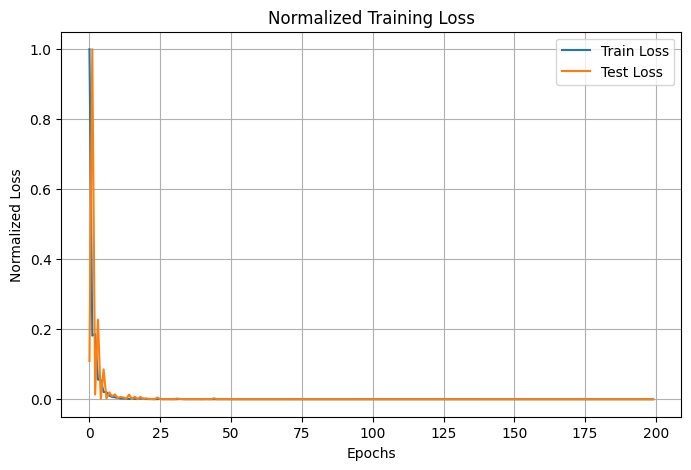

Fold 4
Epoch 0 | Loss train: 59634.442959 | Loss test: 1336.489929 | lr = 0.01
Epoch 10 | Loss train: 52.766587 | Loss test: 135.302834 | lr = 0.01
Epoch 20 | Loss train: 11.620346 | Loss test: 1.003306 | lr = 0.01
Epoch 30 | Loss train: 5.779252 | Loss test: 0.929524 | lr = 0.01
Epoch 40 | Loss train: 4.792391 | Loss test: 17.580503 | lr = 0.01
Epoch 50 | Loss train: 2.307352 | Loss test: 0.712225 | lr = 0.01
Epoch 60 | Loss train: 0.512604 | Loss test: 0.416246 | lr = 0.001
Epoch 70 | Loss train: 0.446697 | Loss test: 0.526143 | lr = 0.001
Epoch 80 | Loss train: 0.352121 | Loss test: 0.288538 | lr = 0.001
Epoch 90 | Loss train: 0.305712 | Loss test: 0.361418 | lr = 0.001
Epoch 100 | Loss train: 0.309584 | Loss test: 0.334743 | lr = 0.001
Epoch 110 | Loss train: 0.266749 | Loss test: 0.231266 | lr = 0.001
Epoch 120 | Loss train: 0.232789 | Loss test: 0.316344 | lr = 0.001
Epoch 130 | Loss train: 0.279216 | Loss test: 0.356903 | lr = 0.001
Epoch 140 | Loss train: 0.176806 | Loss test: 

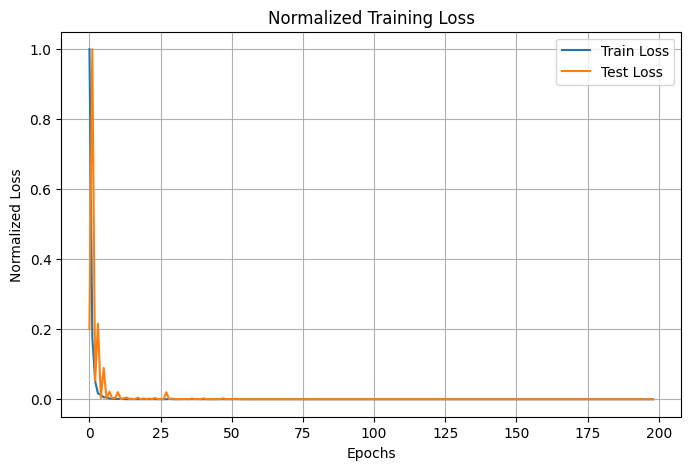

Fold 5
Epoch 0 | Loss train: 44699.787666 | Loss test: 663.252747 | lr = 0.01
Epoch 10 | Loss train: 227.640159 | Loss test: 10.494715 | lr = 0.01
Epoch 20 | Loss train: 23.727220 | Loss test: 2.812740 | lr = 0.01
Epoch 30 | Loss train: 10.592713 | Loss test: 12.691220 | lr = 0.01
Epoch 40 | Loss train: 2.672261 | Loss test: 2.596981 | lr = 0.01
Epoch 50 | Loss train: 2.725001 | Loss test: 4.457665 | lr = 0.01
Epoch 60 | Loss train: 3.457365 | Loss test: 3.287796 | lr = 0.01
Epoch 70 | Loss train: 2.130673 | Loss test: 7.285316 | lr = 0.01
Epoch 80 | Loss train: 0.608621 | Loss test: 0.757679 | lr = 0.001
Epoch 90 | Loss train: 0.386732 | Loss test: 0.797856 | lr = 0.001
Epoch 100 | Loss train: 0.294533 | Loss test: 0.873866 | lr = 0.001
Epoch 110 | Loss train: 0.274499 | Loss test: 0.714212 | lr = 0.001
Epoch 120 | Loss train: 0.272263 | Loss test: 1.160977 | lr = 0.001
Epoch 130 | Loss train: 0.239486 | Loss test: 0.903971 | lr = 0.001
Epoch 140 | Loss train: 0.208940 | Loss test: 1.

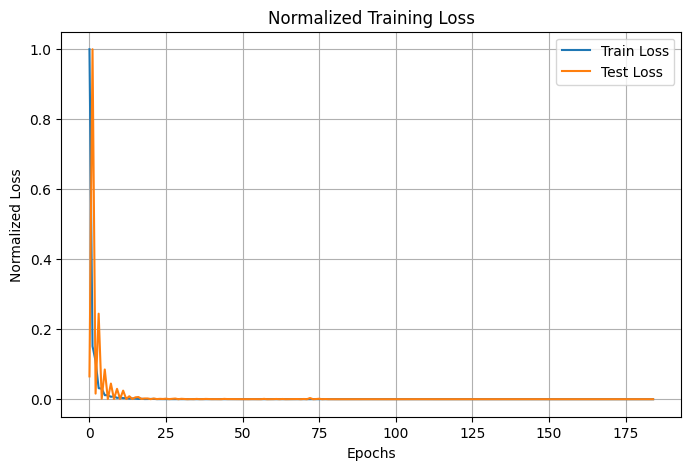

Cross-Validation finished with mean error across 5 subsets = 0.3239098537713289, evaluating final model...
Epoch 0 | Loss train: 41301.928157 | lr = 0.01
Epoch 10 | Loss train: 88.388152 | lr = 0.01
Epoch 20 | Loss train: 7.464428 | lr = 0.01
Epoch 30 | Loss train: 3.220209 | lr = 0.01
Epoch 40 | Loss train: 8.391974 | lr = 0.01
Epoch 50 | Loss train: 2.108780 | lr = 0.01
Epoch 60 | Loss train: 0.443036 | lr = 0.001
Epoch 70 | Loss train: 0.361973 | lr = 0.001
Epoch 80 | Loss train: 0.310903 | lr = 0.001
Epoch 90 | Loss train: 0.288958 | lr = 0.001
Epoch 100 | Loss train: 0.224744 | lr = 0.001
Epoch 110 | Loss train: 0.228635 | lr = 0.001
Epoch 120 | Loss train: 0.164435 | lr = 0.0001
Epoch 130 | Loss train: 0.187503 | lr = 0.0001
Epoch 140 | Loss train: 0.151522 | lr = 0.0001
Epoch 150 | Loss train: 0.150034 | lr = 1e-05
Epoch 160 | Loss train: 0.139062 | lr = 1e-05
Epoch 170 | Loss train: 0.143069 | lr = 1e-05
Epoch 180 | Loss train: 0.151118 | lr = 1e-05
Epoch 190 | Loss train: 0.15

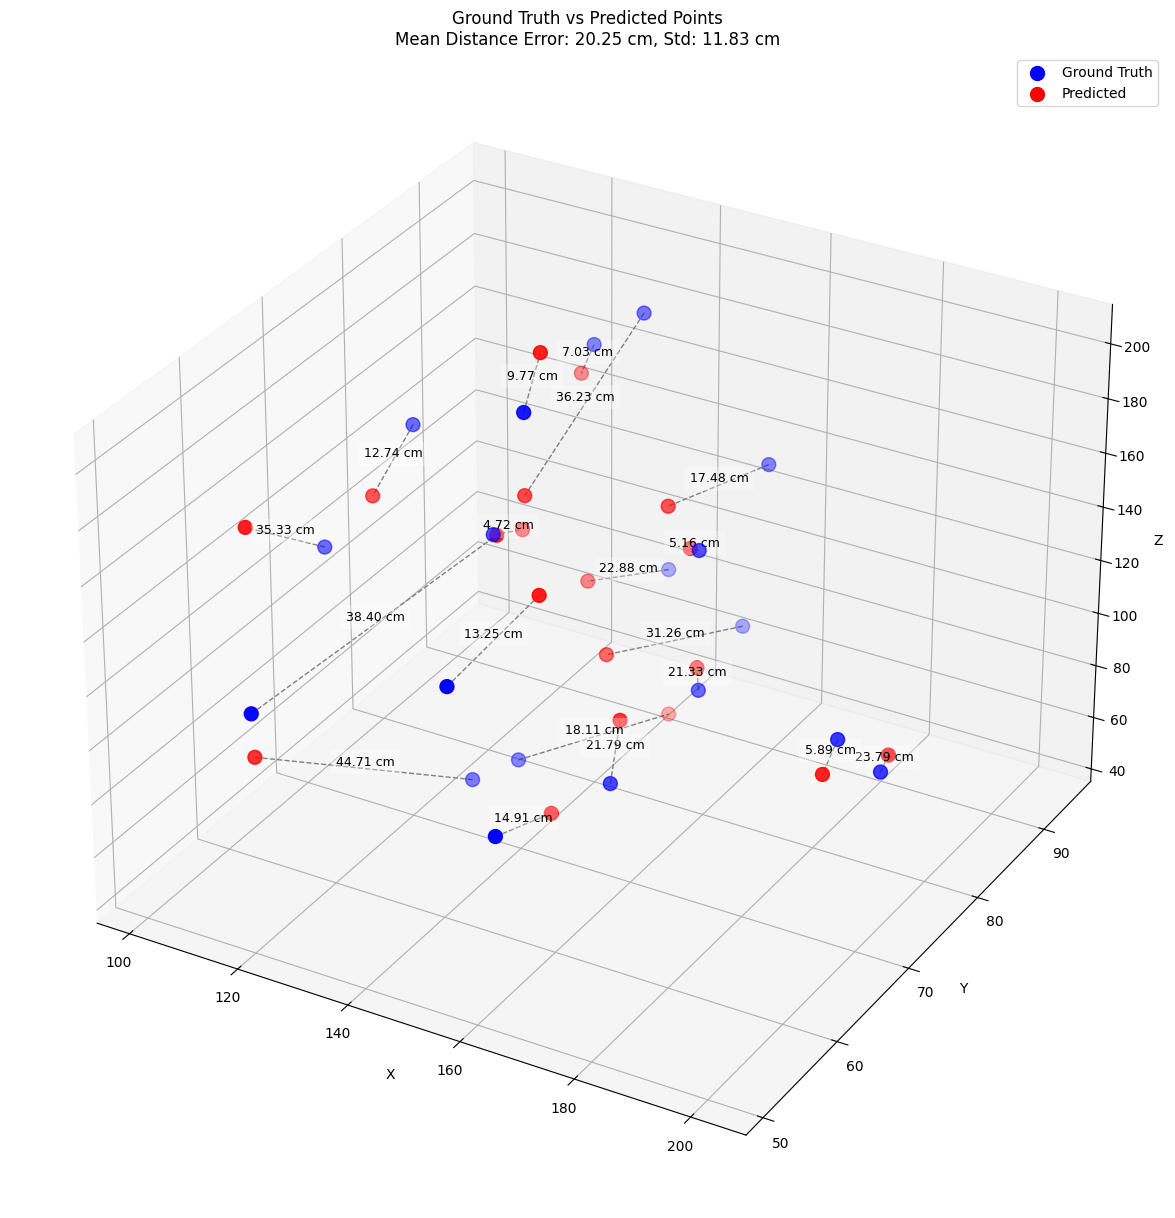

In [ ]:
loss_fn = nn.MSELoss()
optim = torch.optim.RMSprop
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10, 'min_lr' : 1e-5}
model_params = {'input_size': input_len, 'output_size': output_len, 'hidden_units': 64}
early_stop_params = {'patience': 90, 'min_delta' : 1e-5, 'verbose' : False, 'path':'temp_model.pth'}
num_splits = 5
epoch = 200

leakyrelu_2_rms = cross_validation(cv_train_data,cv_train_labels,cv_test_data,cv_test_labels, n_splits=num_splits, model= LeakyReLUModel2_RMS, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device)

### Αρχιτεκτονική 7

#### 1D CNN

In [ ]:
def data_func_cnn(X_train,X_test,y_train,y_test, batch_size=32, test_size=0.2):

    for dataset in [X_train, X_test]:
        for i in range(len(dataset)):
            for j in range(dataset.shape[2]):
                if (j + 1) % 4 == 0:
                    dataset[i, :, j] -= np.min(dataset[i, :, j])
                    
    abs_max = np.abs(X_train).max(axis=(0,1))  # max per feature over (samples, time)

    # Reshape to 4 rows, 4 columns
    abs_max = abs_max.reshape(4, 4)

    # Find the max of each column
    col_max = abs_max.max(axis=0)

    col_max[0], col_max[1] = max(col_max[0], col_max[1]), max(col_max[0], col_max[1])

    # Replace each column with its max value
    abs_max = np.tile(col_max, (abs_max.shape[0], 1))

    abs_max = abs_max.flatten()

    # Prevent division by zero
    abs_max[abs_max == 0] = 1.0

    # Normalize per feature
    X_train_scaled = X_train / abs_max  # shape (N_train, 500, 4)
    X_test_scaled = X_test / abs_max    # shape (N_test, 500, 4)
    

    # Scale Y (labels)
    scaler_Y = StandardScaler()
    y_train_scaled = scaler_Y.fit_transform(y_train)
    y_test_scaled = scaler_Y.transform(y_test)

    # Convert to tensors and move channel dim for CNN input (B, C, L)
    # Current: (B, 1000, 4) → CNN wants (B, 4, 1000)
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).permute(0, 2, 1)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).permute(0, 2, 1)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

    # Create datasets
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    test_data = TensorDataset(X_test_tensor, y_test_tensor)

    # Data loaders
    g = torch.Generator()
    g.manual_seed(42)

    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, generator=g)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

    return train_loader, test_loader, scaler_Y

In [ ]:
train_loader_cnn, test_loader_cnn, scaler_rev_cnn = data_func_cnn(cv_train_data, cv_test_data, cv_train_labels, cv_test_labels)

Epoch 0 | Loss train: 1.003123 | Loss test: 0.891170 | lr = 0.001
Epoch 10 | Loss train: 0.235077 | Loss test: 4.281041 | lr = 0.001
Epoch 20 | Loss train: 0.167317 | Loss test: 1.363756 | lr = 0.001
Epoch 30 | Loss train: 0.127632 | Loss test: 0.574516 | lr = 0.0001
Epoch 40 | Loss train: 0.112314 | Loss test: 0.390306 | lr = 0.0001
Epoch 50 | Loss train: 0.055730 | Loss test: 0.321260 | lr = 0.0001
Epoch 60 | Loss train: 0.109493 | Loss test: 0.400154 | lr = 0.0001
Epoch 70 | Loss train: 0.109028 | Loss test: 0.340990 | lr = 1e-05
Epoch 80 | Loss train: 0.088174 | Loss test: 0.320341 | lr = 1e-05
Epoch 90 | Loss train: 0.113619 | Loss test: 0.304556 | lr = 1e-05
Epoch 100 | Loss train: 0.095516 | Loss test: 0.317065 | lr = 1e-05
Epoch 110 | Loss train: 0.064675 | Loss test: 0.325059 | lr = 1e-05
Epoch 120 | Loss train: 0.104168 | Loss test: 0.346834 | lr = 1e-05
Epoch 130 | Loss train: 0.165092 | Loss test: 0.328434 | lr = 1e-05
Epoch 140 | Loss train: 0.065802 | Loss test: 0.341725 

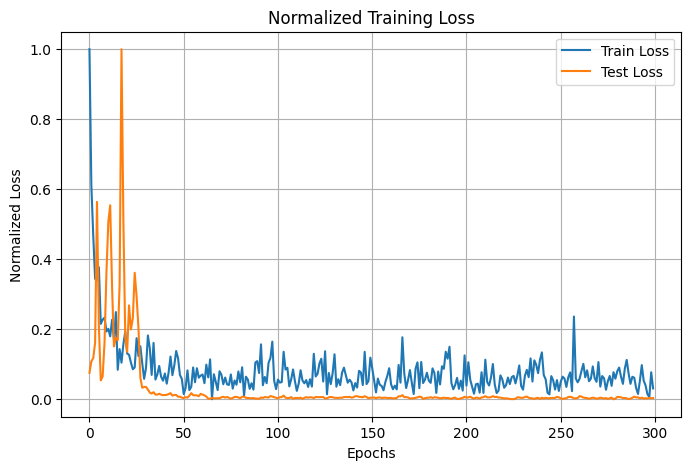

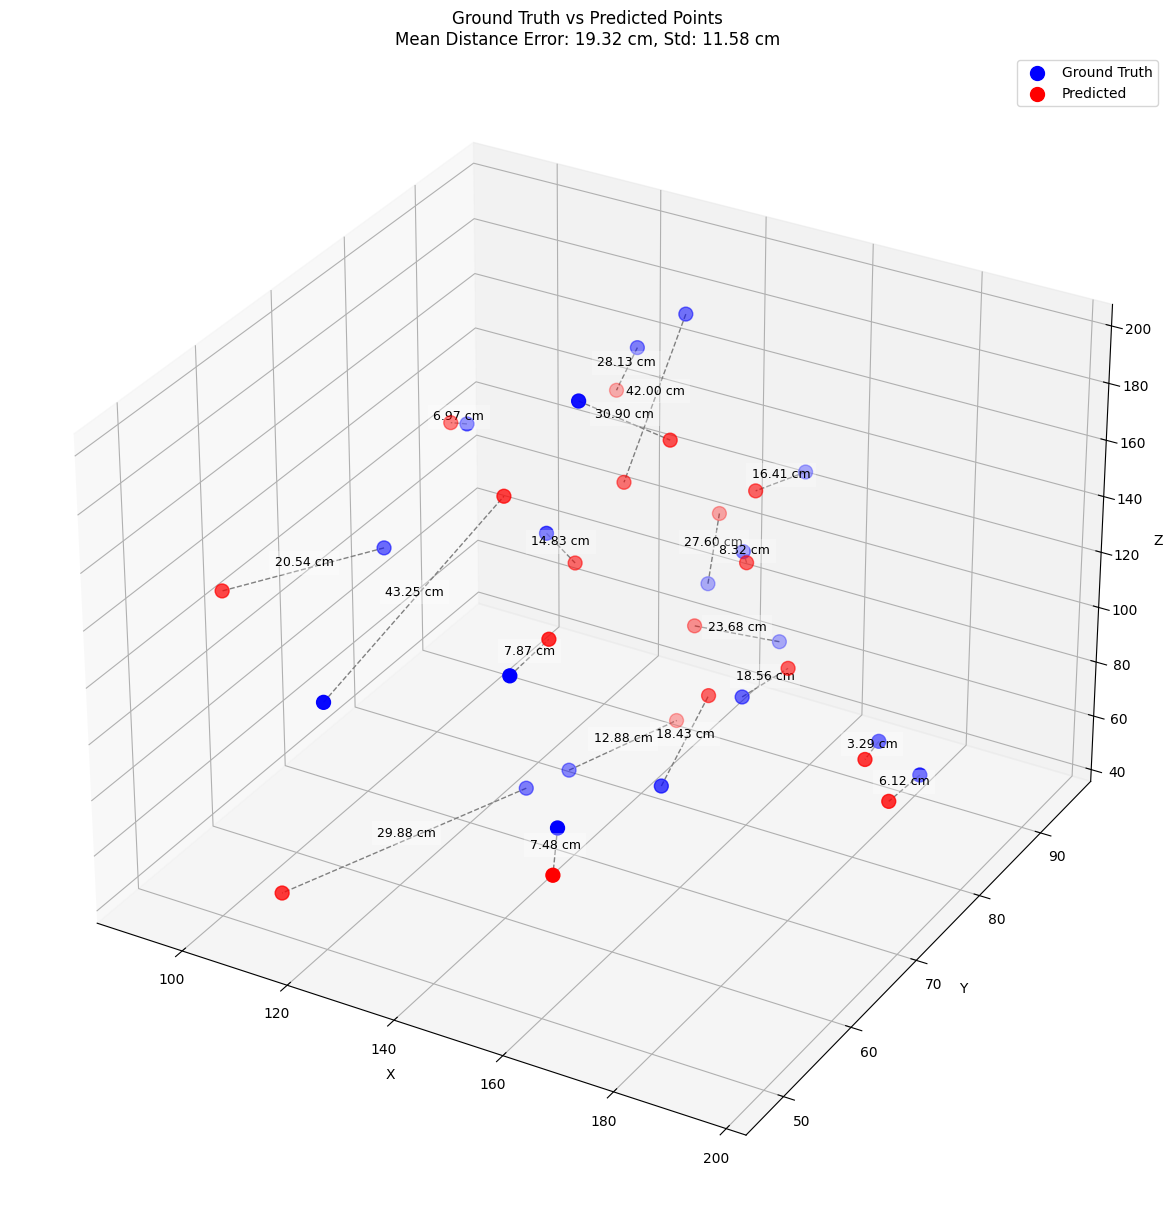

In [ ]:
import torch.nn as nn
import torch.nn.init as init

class CNN1DModel(nn.Module):
    def __init__(self, input_channels=3, output_size=2):
        super(CNN1DModel, self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv1d(in_channels=input_channels, out_channels=16, kernel_size=110, stride=1, padding=0),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),

            #nn.Conv1d(10, 20, 84, stride=1, padding=0),
            #nn.BatchNorm1d(20),
            #nn.ReLU(),
            #nn.MaxPool1d(2),

            nn.Conv1d(16, 32, 54, stride=1, padding=0),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 48, 27, stride=1, padding=0),
            nn.BatchNorm1d(48),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
        )

        self.fc = nn.Sequential(
            #nn.Linear(32, 16),
            #nn.Dropout(0.1),
            #nn.LeakyReLU(0.1),
            nn.Linear(48, output_size)
        )
            
    

        # Apply weight initialization
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm1d):
                init.ones_(m.weight)
                init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    init.zeros_(m.bias)

    def forward(self, x):
        x = self.conv_stack(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


# Instantiate the model
model_16 = CNN1DModel(input_channels=16, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-3


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_16.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, min_lr= 1e-5)
# Initialize early stopping
early_stopper = EarlyStopping(patience=100, min_delta=1e-5, verbose=False, path='temp_model.pth')

# Load the data
arr1, arr2, irrelevant_1, irrelevant_2 = train_test_model(epoch = 300,model = model_16, train_loader= train_loader_cnn, test_loader= test_loader_cnn, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device, test= True)

plot_results(arr1, arr2)

cnn_model = eval_model_3d(model_16, test_loader_cnn, scaler_rev_cnn, device)

In [ ]:
cnn_model

{'model_name': 'CNN1DModel',
 'mean_distance_error_cm': 19.323328018188477,
 'std': 11.577341079711914}

***

### Αρχιτεκτονική 8

#### RNN

In [ ]:
def data_func_cv_rnn(input_array, labels, train_idx, val_idx, batch_size=32):
    # Trim into subset
    X_train_raw = input_array[train_idx]
    X_test_raw = input_array[val_idx]
    y_train = labels[train_idx, :]
    y_test = labels[val_idx, :]

    for dataset in [X_train_raw, X_test_raw]:
        for i in range(len(dataset)):
            for j in range(dataset.shape[2]):
                if (j + 1) % 4 == 0:
                    dataset[i, :, j] -= np.min(dataset[i, :, j])
                    
    abs_max = np.abs(X_train_raw).max(axis=(0,1))  # max per feature over (samples, time)

    # Reshape to 4 rows, 4 columns
    abs_max = abs_max.reshape(4, 4)

    # Find the max of each column
    col_max = abs_max.max(axis=0)

    col_max[0], col_max[1] = max(col_max[0], col_max[1]), max(col_max[0], col_max[1])

    # Replace each column with its max value
    abs_max = np.tile(col_max, (abs_max.shape[0], 1))

    abs_max = abs_max.flatten()

    # Prevent division by zero
    abs_max[abs_max == 0] = 1.0

    # Normalize per feature
    X_train_norm = X_train_raw / abs_max  
    X_test_norm = X_test_raw / abs_max  

    # Now reshape for linear model
    X_train_scaled = X_train_norm
    X_test_scaled = X_test_norm

    # Scale Y with StandardScaler (correct approach)
    scaler_Y = StandardScaler()
    y_train_scaled = scaler_Y.fit_transform(y_train)
    y_test_scaled = scaler_Y.transform(y_test)

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

    # Dataloaders
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    test_data = TensorDataset(X_test_tensor, y_test_tensor)

    g = torch.Generator()
    g.manual_seed(42)

    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, generator=g)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

    return train_loader, test_loader, scaler_Y


In [ ]:
def data_func_eval_rnn(X_main, X_holdout, y_main, y_holdout, batch_size = 32):
    for dataset in [X_main, X_holdout]:
        for i in range(len(dataset)):
            for j in range(dataset.shape[2]):
                if (j + 1) % 4 == 0:
                    dataset[i, :, j] -= np.min(dataset[i, :, j])
                    
    abs_max = np.abs(X_main).max(axis=(0,1))  # max per feature over (samples, time)

    # Reshape to 4 rows, 4 columns
    abs_max = abs_max.reshape(4, 4)

    # Find the max of each column
    col_max = abs_max.max(axis=0)

    col_max[1] = col_max[0]

    # Replace each column with its max value
    abs_max = np.tile(col_max, (abs_max.shape[0], 1))
    abs_max = abs_max.flatten()

    # Prevent division by zero
    abs_max[abs_max == 0] = 1.0

    # Normalize per feature
    X_train_norm = X_main / abs_max  # shape (N_train, 500, 4)
    X_test_norm = X_holdout / abs_max    # shape (N_test, 500, 4)

    # Now reshape for linear model
    X_train_scaled = X_train_norm
    X_test_scaled = X_test_norm

    # Scale Y with StandardScaler (correct approach)
    scaler_Y = StandardScaler()
    y_main_scaled = scaler_Y.fit_transform(y_main)
    y_holdout_scaled = scaler_Y.transform(y_holdout)

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_main_tensor = torch.tensor(y_main_scaled, dtype=torch.float32)
    y_holdout_tensor = torch.tensor(y_holdout_scaled, dtype=torch.float32)

    # Dataloaders
    train_data = TensorDataset(X_train_tensor, y_main_tensor)
    test_data = TensorDataset(X_test_tensor, y_holdout_tensor)

    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

    return train_loader, test_loader, scaler_Y

In [ ]:
def cross_validation_rnn(X_main, X_holdout, y_main,y_holdout, n_splits, model, model_param, loss_fn, optimizer_1, optimizer_param, scheduler_param, early_stopper_param, epochs, device, verbose = True):

    ################## FOR PHASE RELOCK ################
    global labels_holdout
    global info_holdout
    labels_holdout = y_holdout
    info_holdout = X_holdout
    ####################################################

    # Initialize KFold
    kf = KFold(n_splits= n_splits, shuffle= True, random_state= 42)

    # Initialize arrays to store losses and epochs
    cv_losses = []
    epoch_array = []

    # Loop over the folds to perform cross-validation
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_main)):
        
        print(f"Fold {fold_idx + 1}")

        train_loader, test_loader, _ = data_func_cv_rnn(X_main, y_main, train_idx, val_idx, batch_size=BATCH_SIZE)
        # Instantiate the model
        model_0 = model(**model_param)

        loss_fn = loss_fn
        optimizer = optimizer_1(model_0.parameters(), **optimizer_param)

        # Initialize the scheduler
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, **scheduler_param)

        # Initialize early stopping
        early_stopper = EarlyStopping(**early_stopper_param)

        # Load the data
        arr1, arr2, best_loss, epoch_stop = train_test_model(epoch = epochs,model = model_0, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device, test= True, verbose = verbose)
        
        if verbose == True:
            plot_results(arr1, arr2)

        cv_losses.append(best_loss)
        epoch_array.append(epoch_stop)
    
    # Evaluate the final model
    train_loader, test_loader, scaler_Y = data_func_eval_rnn(X_main, X_holdout, y_main, y_holdout, batch_size=BATCH_SIZE)
    print(f"Cross-Validation finished with mean error across {n_splits} subsets = {np.mean(cv_losses)}, evaluating final model...")

    # Instantiate the model
    final_model = model(**model_param)

    final_optimizer = optimizer_1(final_model.parameters(), **optimizer_param)

    # Initialize the scheduler
    scheduler = lr_scheduler.ReduceLROnPlateau(final_optimizer, **scheduler_param)

    # Load the data
    arr1= train_test_model(epoch = np.max(epoch_array),model = final_model, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=final_optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device, test= False, verbose= verbose)

    result = eval_model_3d(model= final_model, data_loader= test_loader, scaler= scaler_Y, verbose= True)
    return result

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Cross-Validation finished with mean error across 5 subsets = 0.2884513434022665, evaluating final model...


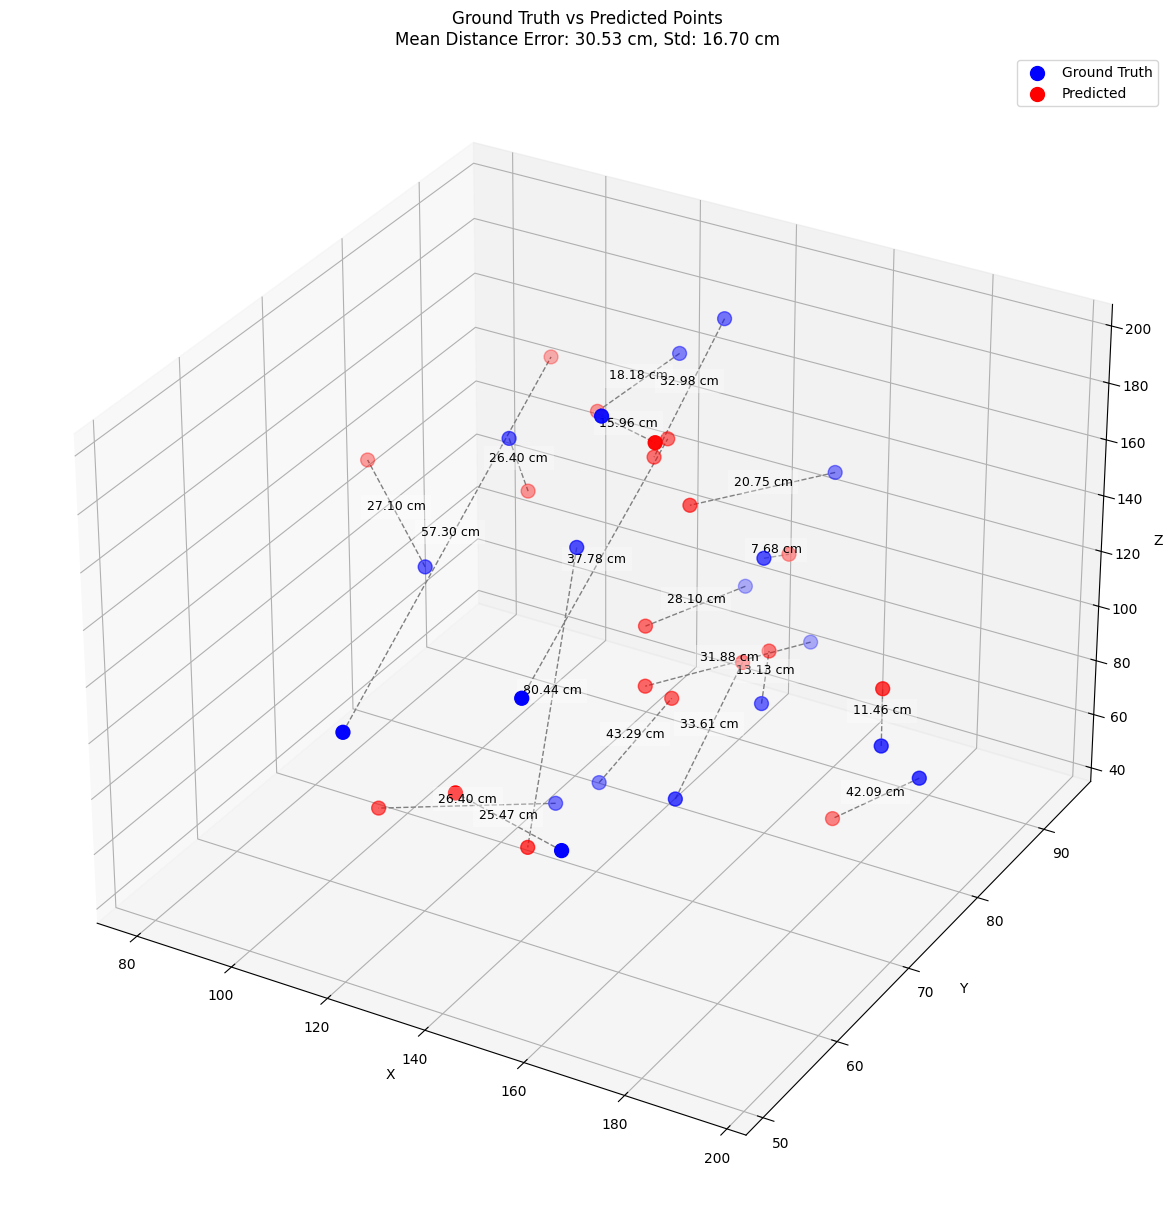

In [ ]:
import torch.nn.functional as F

class EnhancedRNN(nn.Module):
    def __init__(self, input_size=16, hidden_size=32, num_layers=2, output_size=3, dropout=0.1):
        super().__init__()
        # LSTM with independent dropout masks for forward/backward passes
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional= False,
            dropout=0 if num_layers == 1 else dropout / 2
        )

        # Reduced FC architecture
        self.fc1 = nn.Linear( 1 * hidden_size, hidden_size) # BILSTM *2
        self.fc2 = nn.Linear(hidden_size, output_size)

        # Minimal normalization and dropout
        self.ln1 = nn.LayerNorm( 1 * hidden_size) # BILSTM *2
        self.dropout = nn.Dropout(dropout)

        self._init_weights()

    def _init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)
                n = param.size(0)
                param.data[n // 4:n // 2].fill_(1)

        for fc in [self.fc1, self.fc2]:
            nn.init.xavier_normal_(fc.weight)
            nn.init.constant_(fc.bias, 0.1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out[:, -1, :])
        lstm_out = self.ln1(lstm_out)

        out = F.relu(self.fc1(lstm_out))
        out = self.dropout(out)

        return self.fc2(out)



loss_fn = nn.MSELoss()
optim = torch.optim.Adam
optimizer_params = {
    'lr': 1e-3,
}
scheduler_params = {
    'mode':'min',
    'factor':0.1,
    'patience':10,
    'min_lr': 1e-5
}
model_params = {'input_size': 16, 'output_size': output_len,}
early_stop_params = {
    'patience': 90,  # Increased patience
    'min_delta': 1e-6,  # Smaller delta
    'verbose': False,
    'path':'temp_model.pth'
}
num_splits = 5
epoch = 200
BATCH_SIZE = 32

rnn = cross_validation_rnn(cv_train_data,cv_test_data,cv_train_labels,cv_test_labels, n_splits=num_splits, model= EnhancedRNN, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device, verbose = False)

In [ ]:
rnn

{'model_name': 'EnhancedRNN',
 'mean_distance_error_cm': 27.617168426513672,
 'std': 13.717718124389648}

***

## Results

Results for interpolation size = 385

In [ ]:
#compare_results = pd.DataFrame([leakyrelu, leakyrelu_4, leakyrelu_2,leakyrelu_2_rms, relu_model,dropout_model, sigmoid_model, tanh_model, cnn_model, relu_dropout_model, relu_model_256, relu_model_64, rnn])
compare_results = pd.DataFrame([leakyrelu, leakyrelu_4, leakyrelu_2,leakyrelu_2_rms, relu_model,dropout_model, cnn_model, relu_dropout_model, relu_model_256, relu_model_64,rnn])
#compare_results = compare_results._append(xgb_res, ignore_index = True)
#compare_results = compare_results._append(epoch_res, ignore_index = True)
compare_results.sort_values(by = 'mean_distance_error_cm', ascending= True, inplace= True)

compare_results

model_name  mean_distance_error_cm        std
0          LeakyReLUModel               18.610186   8.957881
5   LeakyReLUModelDropout               18.904259   9.193876
6              CNN1DModel               19.323328  11.577341
3     LeakyReLUModel2_RMS               20.252075  11.833974
9               ReLUModel               21.041378  12.071958
4               ReLUModel               21.614504  10.561244
1         LeakyReLUModel4               21.978693  11.851048
2         LeakyReLUModel2               22.581764  11.592122
8               ReLUModel               23.983629  11.215926
7        ReLUModelDropout               24.332542  11.814595
10            EnhancedRNN               30.525963  16.703348

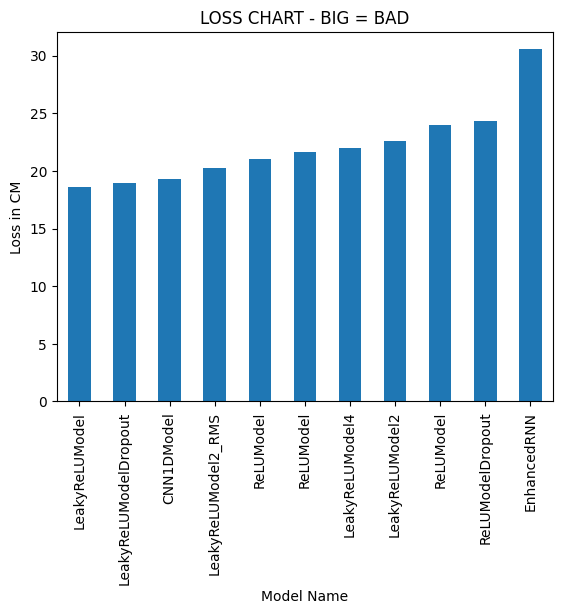

In [ ]:
# Visualize our model results
compare_results.set_index("model_name")["mean_distance_error_cm"].plot(kind="bar")
plt.xlabel("Model Name")
plt.ylabel("Loss in CM")
plt.title("LOSS CHART - BIG = BAD")
plt.show()

***

Results For Interpolation Size = 500

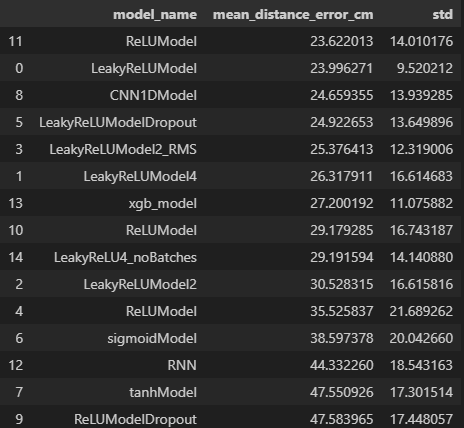

***

# Hyperparameter Tuning

Θα μελετήσουμε ποιες είναι οι βέλτιστες παράμετροι για το μοντέλο LeakyReLU με dropout.

In [ ]:
class LeakyReLUModelDropout(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 256):
        super(LeakyReLUModelDropout, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(in_features= hidden_units, out_features= int(hidden_units/2)),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            nn.Linear(in_features= int(hidden_units/2), out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Θα πειράξουμε lr , optimizer, batch_size

In [ ]:
import time

# Loss function and static model settings
loss_fn = nn.MSELoss()
model_params = {'input_size': input_len, 'output_size': output_len}
num_splits = 5
epochs = 300

scheduler_params = {
    'mode': 'min',
    'factor': 0.1,
    'patience': 10,
    'min_lr': 1e-5
}

early_stop_params = {
    'patience': 90,
    'min_delta': 1e-5,
    'verbose': False,
    'path': 'temp_model.pth'
}

# Hyperparameter grids
optimizers = [torch.optim.Adam, torch.optim.AdamW]
learning_rates = [1e-2, 1e-3]
batch_sizes = [16, 32, 64]

# Store results here: each key is a descriptive string, value is result dict
grid_search_results = {}

# Grid search loop
for optimizer_class in optimizers:
    for lr in learning_rates:
        for batch_size in batch_sizes:
            config_name = f"{optimizer_class.__name__}_lr{lr}_batch{batch_size}"
            print(f"\nTesting Config: {config_name}")

            optimizer_params = {'lr': lr}
            start_time = time.time()

            result = cross_validation(
                X_main=cv_train_data,
                y_main=cv_train_labels,
                X_holdout=cv_test_data,
                y_holdout=cv_test_labels,
                n_splits=num_splits,
                model=LeakyReLUModel,
                model_param=model_params,
                loss_fn=loss_fn,
                optimizer_1=optimizer_class,
                optimizer_param=optimizer_params,
                scheduler_param=scheduler_params,
                early_stopper_param=early_stop_params,
                epochs=epochs,
                device=device,
                verbose=False
            )

            duration = time.time() - start_time
            print(f"Finished {config_name} in {duration:.2f}s | Result: Mean Error = {result['mean_distance_error_cm']:.4f}, Std = {result['std']:.4f}")

            # Save results
            grid_search_results[config_name] = {
                'result': result,
                'duration': duration,
                'optimizer': optimizer_class.__name__,
                'learning_rate': lr,
                'batch_size': batch_size
            }


In [ ]:
# Find config with lowest mean_distance_error_cm error
best_config = min(grid_search_results.items(), key=lambda x: x[1]['result']['mean_distance_error_cm'])
print(f"\nBest Config: {best_config[0]} | mean_distance_error_cm Error: {best_config[1]['result']['mean_distance_error_cm']:.4f} | Std: {best_config[1]['result']['std']:.4f}")



Best Config: AdamW_lr0.001_batch16 | mean_distance_error_cm Error: 27.1607 | Std: 20.0248


***

# Phase ReLock

Ορίζουμε την συνάρτηση κόστους

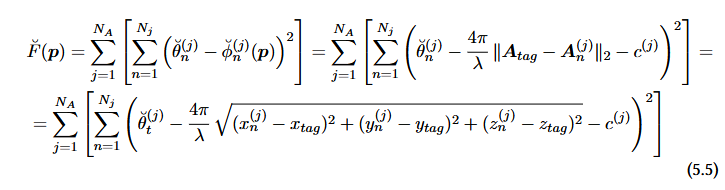

In [ ]:
def theoretical_3D(x, x1_antenna, y1_antenna, z1_antenna, phase1, x2_antenna, y2_antenna, z2_antenna, phase2,x3_antenna, y3_antenna, z3_antenna, phase3,x4_antenna, y4_antenna, z4_antenna, phase4, lamda):
    # x[0] = x_tag
    # x[1] = y_tag
    # x[2] = irrelevant c (phase offset)
    F = 0
    F += (phase1 - x[3] - (4*np.pi/lamda) * np.sqrt((x1_antenna - x[0])**2 + (y1_antenna - x[1])**2 + (z1_antenna - x[2])**2))**2
    F += (phase2 - x[4] - (4*np.pi/lamda) * np.sqrt((x2_antenna - x[0])**2 + (y2_antenna - x[1])**2 + (z2_antenna - x[2])**2))**2
    F += (phase3 - x[5] - (4*np.pi/lamda) * np.sqrt((x3_antenna - x[0])**2 + (y3_antenna - x[1])**2 + (z3_antenna - x[2])**2))**2
    F += (phase4 - x[6] - (4*np.pi/lamda) * np.sqrt((x4_antenna - x[0])**2 + (y4_antenna - x[1])**2 + (z4_antenna - x[2])**2))**2

    return F

Και στην συνέχεια την συνάρτηση βελτιστοποίησης.

In [ ]:
from scipy.optimize import least_squares

def nonlinear_fit_3D( x1_antenna, y1_antenna, z1_antenna, phase1, x2_antenna, y2_antenna, z2_antenna, phase2,x3_antenna, y3_antenna, z3_antenna, phase3,x4_antenna, y4_antenna, z4_antenna, phase4, lamda, start):
    start = np.asarray(start, dtype=float)  
    
    # Perform nonlinear least squares optimization
    param = least_squares(theoretical_3D, start, args=( x1_antenna, y1_antenna, z1_antenna, phase1, x2_antenna, y2_antenna, z2_antenna, phase2,x3_antenna, y3_antenna, z3_antenna, phase3,x4_antenna, y4_antenna, z4_antenna, phase4, lamda), method='trf', bounds = ([0,0,0,-10000,-10000,-10000,-10000],[300,100,200,10000,10000,10000,10000]))
    

    return param.x[:3]  # Return the optimized parameters

Η ```phase_relock``` δέχεται σαν ορίσματα το set (info, labels) που κρατιέται έξω από το training.

Κάνει optimize πάνω στα tags του holdout set.

Τέλος τυπώνει ένα παρόμοιο δίαγραμμα όπως και στα μοντέλα.

In [ ]:
def phase_relock(info_holdout, labels_holdout):
    """
    Performs 3D localization optimization for RFID tags using phase measurements from two antennas.
    """
    # Constants
    FREQ = 866e6  # RFID tag frequency (Hz)
    C = 299792458.0  # Speed of light (m/s)
    METERS_TO_CM = 100  # Conversion factor (100 = meters, 1 = cm)
    LAMBDA_SIGNAL = C / FREQ  # Wavelength of the signal
    
    # Storage arrays
    results, errors = [], []
    
    # Optimization loop
    for i in range(len(info_holdout)):
        # Extract features and normalize
        x1, y1, z1 = info_holdout[i][:, 0:3].T / METERS_TO_CM
        phase1 = info_holdout[i][:,3]
        x2, y2, z2 = info_holdout[i][:, 4:7].T / METERS_TO_CM
        phase2 = info_holdout[i][:,7]
        x3, y3, z3 = info_holdout[i][:, 8:11].T / METERS_TO_CM
        phase3 = info_holdout[i][:,11]
        x4, y4, z4 = info_holdout[i][:, 12:15].T / METERS_TO_CM
        phase4 = info_holdout[i][:,15]

        phase_min = min([min(phase1),min(phase2), min(phase3), min(phase4)])
        # Perform non-linear optimization
        optimized_result = nonlinear_fit_3D(x1, y1, z1, phase1, x2, y2, z2, phase2, x3, y3, z3, phase3, x4, y4, z4, phase4, LAMBDA_SIGNAL, start=[1, 1, 1, phase_min,phase_min,phase_min,phase_min])
        results.append(optimized_result)
        
        # Compute error (Euclidean distance)
        gt_x, gt_y, gt_z = labels_holdout[i] / METERS_TO_CM
        err = np.sqrt((gt_x - optimized_result[0])**2 + (gt_y - optimized_result[1])**2 + (gt_z - optimized_result[2])**2)
        errors.append(err)
    
    # Convert results to numpy arrays and scale back to cm
    results = np.array(results) * METERS_TO_CM
    errors = np.array(errors) * METERS_TO_CM
    
    # Visualization
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')
    num_points = 20  # Number of points to display
    
    # Plot ground truth and predicted points
    ax.scatter(*labels_holdout[:num_points].T, color='blue', label='Ground Truth', s=100)
    ax.scatter(*results[:num_points].T, color='red', label='Predicted', s=100)
    
    # Draw connecting lines and annotate errors
    for i, (gt, pred) in enumerate(zip(labels_holdout[:num_points], results[:num_points])):
        ax.plot(*zip(gt, pred), color='gray', linestyle='--', linewidth=1)
        mid_point = (gt + pred) / 2
        ax.text(*mid_point, f'{errors[i]:.2f} cm', fontsize=9, ha='center', va='bottom', color='black',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.3))
    
    # Formatting
    ax.set_xlabel('X (cm)')
    ax.set_ylabel('Y (cm)')
    ax.set_zlabel('Z (cm)')
    ax.set_title(f'Ground Truth vs Predicted Points\nMean Distance Error: {np.mean(errors):.2f} cm, Std: {np.std(errors):.2f} cm')
    ax.legend()
    ax.grid(True)
    plt.show()


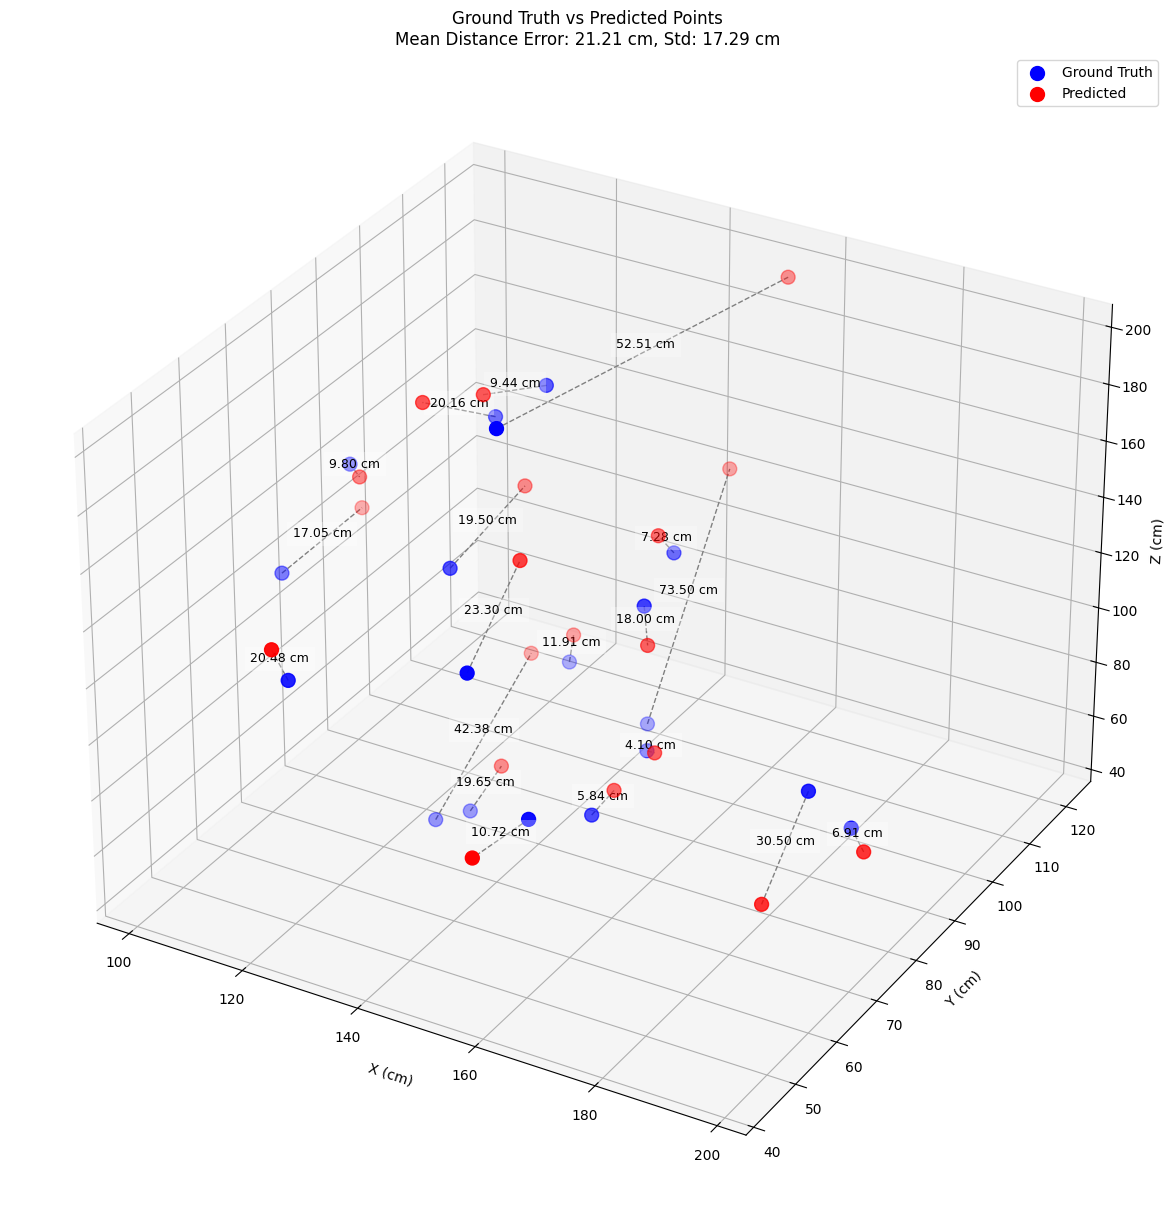

In [ ]:
phase_relock(cv_test_data, cv_test_labels)